In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import umap
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.chdir('../IConNet/')
os.getcwd()

'/home/linh/projects/IConNet'

In [5]:
from einops import rearrange, reduce, repeat

In [6]:
dataset_name = 'meld'
experiment_prefix = "scb12"
log_dir = f'../{experiment_prefix}_models/meld/'
codebook_pretrained_path = f'../scb11_models/ravdess/epoch=220.masked_codebook.pt'
data_dir = "../data/data_preprocessed/"
sr = 16000


In [7]:
data_y = np.load(f'{data_dir}{dataset_name}/preprocessing/{dataset_name}.label4.npy', allow_pickle=True)
print(data_y.shape)
np.unique(data_y)

(4640,)


array(['ang', 'hap', 'neu', 'sad'], dtype=object)

In [14]:
data_x = np.load(f'{data_dir}{dataset_name}/preprocessing/{dataset_name}.audio16k.npy', allow_pickle=True)
print(data_x.shape)

(4639,)


In [8]:
import pandas as pd

In [9]:
df = pd.read_csv(f'{data_dir}{dataset_name}/metadata/data4.csv')
df

filename  emotion emotion_key speaker  gender  duration split  \
0        dia0_utt0.wav  sadness         sad  Phoebe  female     2.793   dev   
1        dia1_utt2.wav  sadness         sad    Joey    male     3.294   dev   
2        dia5_utt0.wav    anger         ang    Ross    male     2.669   dev   
3        dia5_utt2.wav    anger         ang    Ross    male     3.503   dev   
4        dia5_utt3.wav    anger         ang  Rachel  female     4.587   dev   
...                ...      ...         ...     ...     ...       ...   ...   
4634   dia279_utt9.wav  neutral         neu  Monica  female     3.034  test   
4635  dia279_utt11.wav  neutral         neu  Rachel  female     4.754  test   
4636  dia279_utt13.wav  neutral         neu  Rachel  female     4.503  test   
4637  dia279_utt14.wav  neutral         neu    Ross    male     4.252  test   
4638  dia279_utt15.wav  neutral         neu  Monica  female     1.625  test   

                                               filepath  
0     ../../data/meld/full_release/MELD.Raw_audios/d...  
1     ../../data/meld/full_release/MELD.Raw_audios/d...  
2     ../../data/meld/full_release/MELD.Raw_audios/d...  
3     ../../data/meld/full_release/MELD.Raw_audios/d...  
4     ../../data/meld/full_release/MELD.Raw_audios/d...  
...                                                 ...  
4634  ../../data/meld/full_release/MELD.Raw_audios/t...  
4635  ../../data/meld/full_release/MELD.Raw_audios/t...  
4636  ../../data/meld/full_release/MELD.Raw_audios/t...  
4637  ../../data/meld/full_release/MELD.Raw_audios/t...  
4638  ../../data/meld/full_release/MELD.Raw_audios/t...  

[4639 rows x 8 columns]

In [19]:
data_y = df['emotion_key'].values
print(data_y.shape)
np.unique(data_y)

(4639,)


array(['ang', 'hap', 'neu', 'sad'], dtype=object)

In [10]:
from IConNet.acov.audio_vqvae import VqVaeClsLoss
from IConNet.trainer.train_torch import get_dataloader
from IConNet.trainer.train_torch import Trainer_SCB10 as Trainer
from IConNet.acov.model import SCB12 as SCB
from omegaconf import OmegaConf as ocf

sr = 16000
batch_size = 2
in_channels = 1
kernel_size = 511
stride = 125
embedding_dim = 511
num_embeddings = 384
cls_dim = 512
learning_rate = 1e-4
max_num_tokens = 768
num_tokens_per_second = 64
num_classes = 4
commitment_cost = 0.1
num_mamba_block=1

model = SCB(
    in_channels=in_channels,    
    num_embeddings=num_embeddings, 
    stride=stride,
    embedding_dim=embedding_dim, 
    num_classes=num_classes, 
    cls_dim=cls_dim,
    sample_rate=sr,
    commitment_cost=commitment_cost,
    distance_type='euclidean',
    codebook_pretrained_path=codebook_pretrained_path,
    freeze_codebook=True,
    num_mamba_block=num_mamba_block,
    num_tokens_per_second=num_tokens_per_second,
    max_num_tokens=max_num_tokens
)

In [11]:
def tokenize(X):
    X = torch.tensor(X, device=device)[None, None, :]
    tokens, _ = model.tokenize(X)
    return tokens.flatten().detach().cpu().numpy()

In [27]:
model.to(device)
model.eval()

SCB12(
  (classifier): Sequential(
    (0): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=384, out_features=512, bias=False)
    (2): PReLU(num_parameters=512)
    (3): Linear(in_features=512, out_features=4, bias=True)
  )
  (encoder): AudioVQEncoder(
    (tokenizer): SpeechSegmentSelector(
      (pad_fn): PadForConv()
    )
    (vq): AudioVQ(
      (embedding): VectorQuantizer(
        (embedding): Embedding(384, 511)
      )
    )
    (embedding): Embedding(384, 511, padding_idx=0)
    (positional_embedding): Embedding(768, 511)
  )
  (linear_projector): Linear(in_features=511, out_features=512, bias=False)
  (ssl_head): Linear(in_features=512, out_features=384, bias=True)
  (lstm_blocks): LSTM(512, 512, batch_first=True)
)

In [31]:
x0_tokens = tokenize(data_x[0])
print(np.unique(x0_tokens))
x0_tokens

[  1   2   3   4   5  10  14  16  20  21  22  26  32  36  38  39  41  51
  53  56  57  58  63  68  70  73  76  79  84  86  90  94 100 108 117 120
 121 122 130 134 138 141 143 144 149 153 158 159 162 168 185 186 187 188
 193 195 198 200 204 210 219 226 232 233 236 237 238 241 242 243 246 249
 251 254 257 259 270 274 280 291 296 298 299 303 304 305 308 317 319 322
 328 329 330 338 343 346 347 349 351 355 357 358 364 365 368 371 372 378
 379 381]


array([ 32,  32, 149, 149, 233,   5, 153, 153,  56,  56, 270,  57,  41,
       259,  36, 141,  58,  58,  58,   2,   2,   2, 381, 381, 381, 259,
       238,   3,   4,   4,   4, 355, 158, 195, 257, 121, 257, 121, 198,
       187, 187,  32,   4, 257, 298, 237, 186, 328, 328, 299, 246,  86,
       236,  53,  53, 210, 100, 349, 130, 100, 349, 130, 249, 349, 219,
       100,  53, 364, 100, 349, 130, 249, 364, 249, 364, 305, 364, 305,
        10,  10, 364, 305, 305, 319, 364, 305, 364, 249, 364,  94,  94,
        94, 378, 144,   4, 338, 162, 347, 347,   4, 357,   4, 304,  21,
         4,  21,   4, 204, 246, 204, 246,   4, 355, 232,   4, 143,   4,
         4, 298, 371,   4,   4,   4,   4,   4,   4, 371,   4,   4,   4,
       381, 381,   4,  76, 241, 303,  20, 274, 186, 246,   4,  76, 317,
       246,  73,   4,  38, 317, 187,   4, 381,   4, 254, 330,   4, 317,
        76,   4,  16,   4, 120, 296, 371, 134,   4,   4,   4,   4,   4,
         4,   4,   4,   4,   4,   4,   4,   4,   4, 159,   4, 32

In [12]:
import pandas as pd
import IPython.display as ipd
import seaborn as sns

from IConNet.acov.visualize import (
    visualize_speech_codebook, get_embedding_color, 
    visualize_embedding_umap, visualize_training_curves,
    get_embedding_color_v2, get_zcs_color_v2
)

In [13]:
emb = torch.load(model.codebook_pretrained_path)
emb_color, zcs = get_embedding_color_v2(emb)

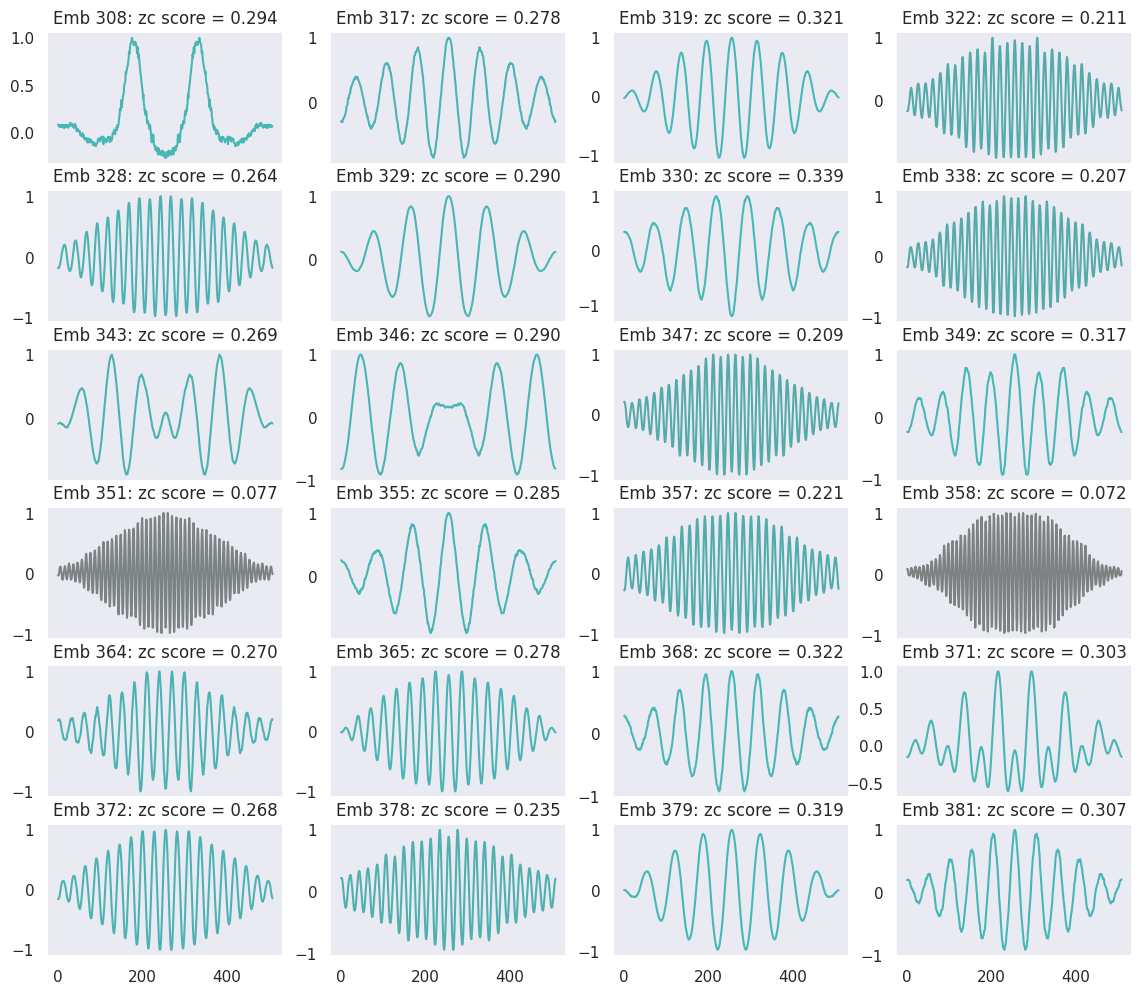

In [32]:
indices = np.unique(x0_tokens)[-24:]
fig, axes = plt.subplots(6, 4, figsize=(14,12), sharex=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    idx = indices[i]
    ax.plot(emb[idx], color=emb_color[idx])
    ax.set_title(f'Emb {idx}: zc score = {zcs[idx]:.3f}')

In [33]:
data_x_tokens = [tokenize(d) for d in data_x]

In [34]:
all_tokens_list = np.concatenate(data_x_tokens)

In [14]:
from collections import Counter

In [36]:
tokens_counter = Counter(all_tokens_list)
tokens_counter

Counter({4: 576737,
         90: 25632,
         129: 22467,
         122: 19008,
         158: 18692,
         187: 18326,
         251: 17440,
         381: 16647,
         243: 16080,
         93: 15912,
         368: 15900,
         193: 15829,
         153: 15611,
         134: 15364,
         315: 15107,
         14: 14844,
         56: 14794,
         97: 14729,
         317: 14489,
         38: 13853,
         308: 13779,
         149: 13554,
         349: 13424,
         355: 13198,
         257: 13064,
         2: 13035,
         364: 12328,
         344: 12232,
         143: 12199,
         5: 11992,
         77: 11596,
         108: 11463,
         76: 11408,
         10: 11368,
         22: 11343,
         270: 11105,
         242: 11049,
         305: 10935,
         16: 10660,
         1: 10574,
         106: 10525,
         58: 10375,
         53: 10140,
         310: 10130,
         100: 10129,
         204: 9933,
         222: 9864,
         274: 9847,
         219: 9

In [37]:
tokens_counter.most_common(24)

[(4, 576737),
 (90, 25632),
 (129, 22467),
 (122, 19008),
 (158, 18692),
 (187, 18326),
 (251, 17440),
 (381, 16647),
 (243, 16080),
 (93, 15912),
 (368, 15900),
 (193, 15829),
 (153, 15611),
 (134, 15364),
 (315, 15107),
 (14, 14844),
 (56, 14794),
 (97, 14729),
 (317, 14489),
 (38, 13853),
 (308, 13779),
 (149, 13554),
 (349, 13424),
 (355, 13198)]

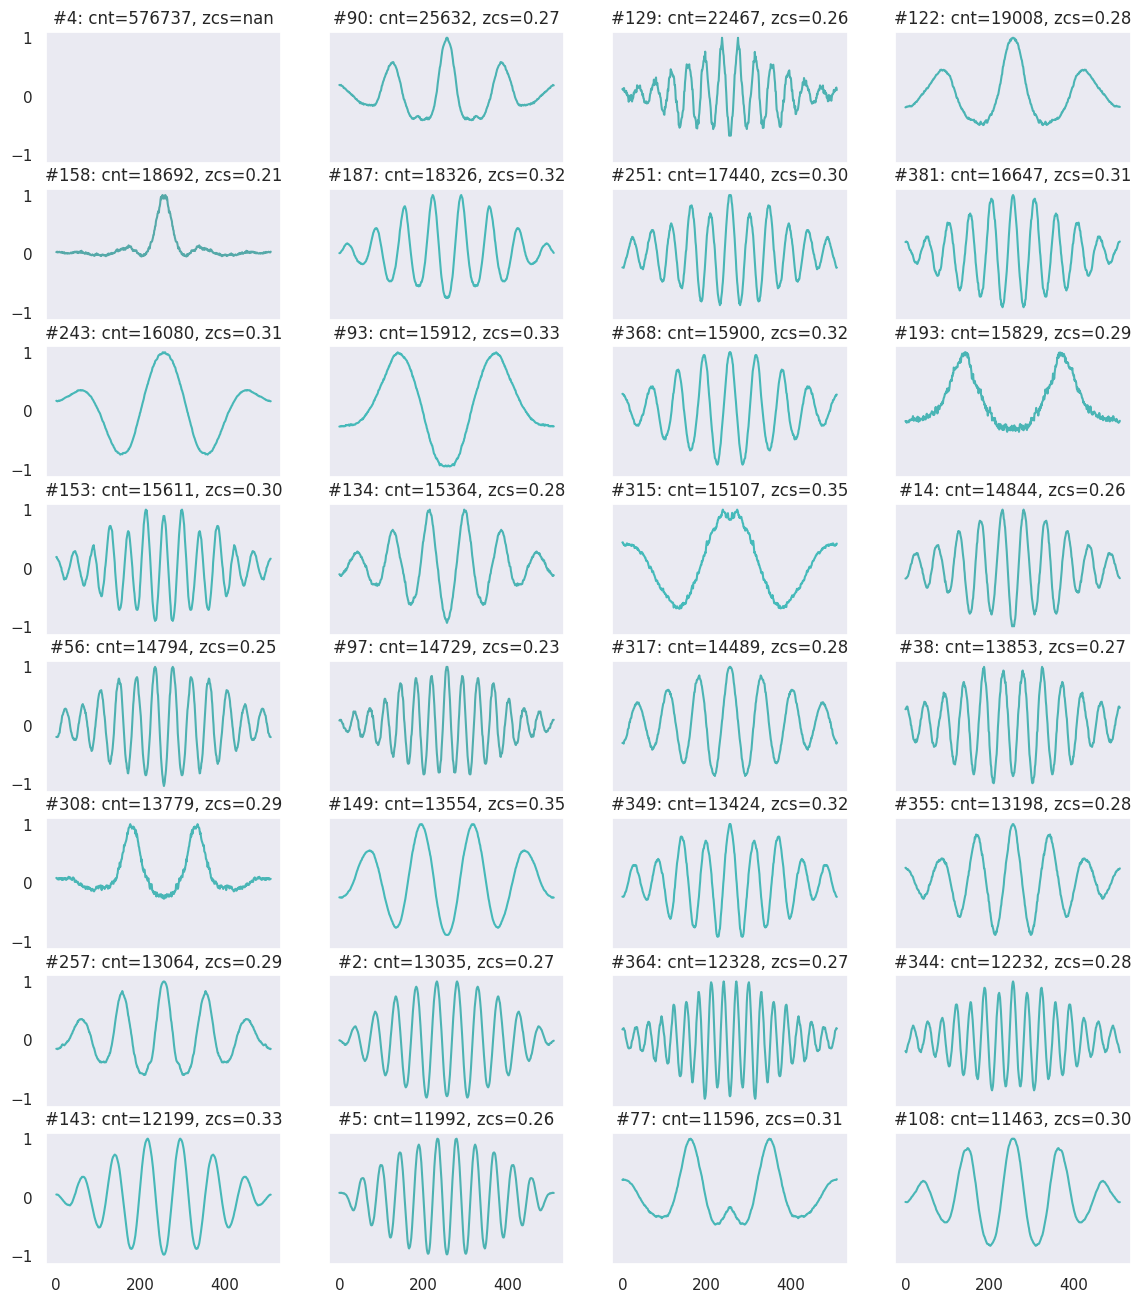

In [39]:
top_counter = tokens_counter.most_common(32)
fig, axes = plt.subplots(8, 4, figsize=(14,16), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    idx, count = top_counter[i]
    ax.plot(emb[idx], color=emb_color[idx])
    ax.set_title(f'#{idx}: cnt={count}, zcs={zcs[idx]:.2f}')

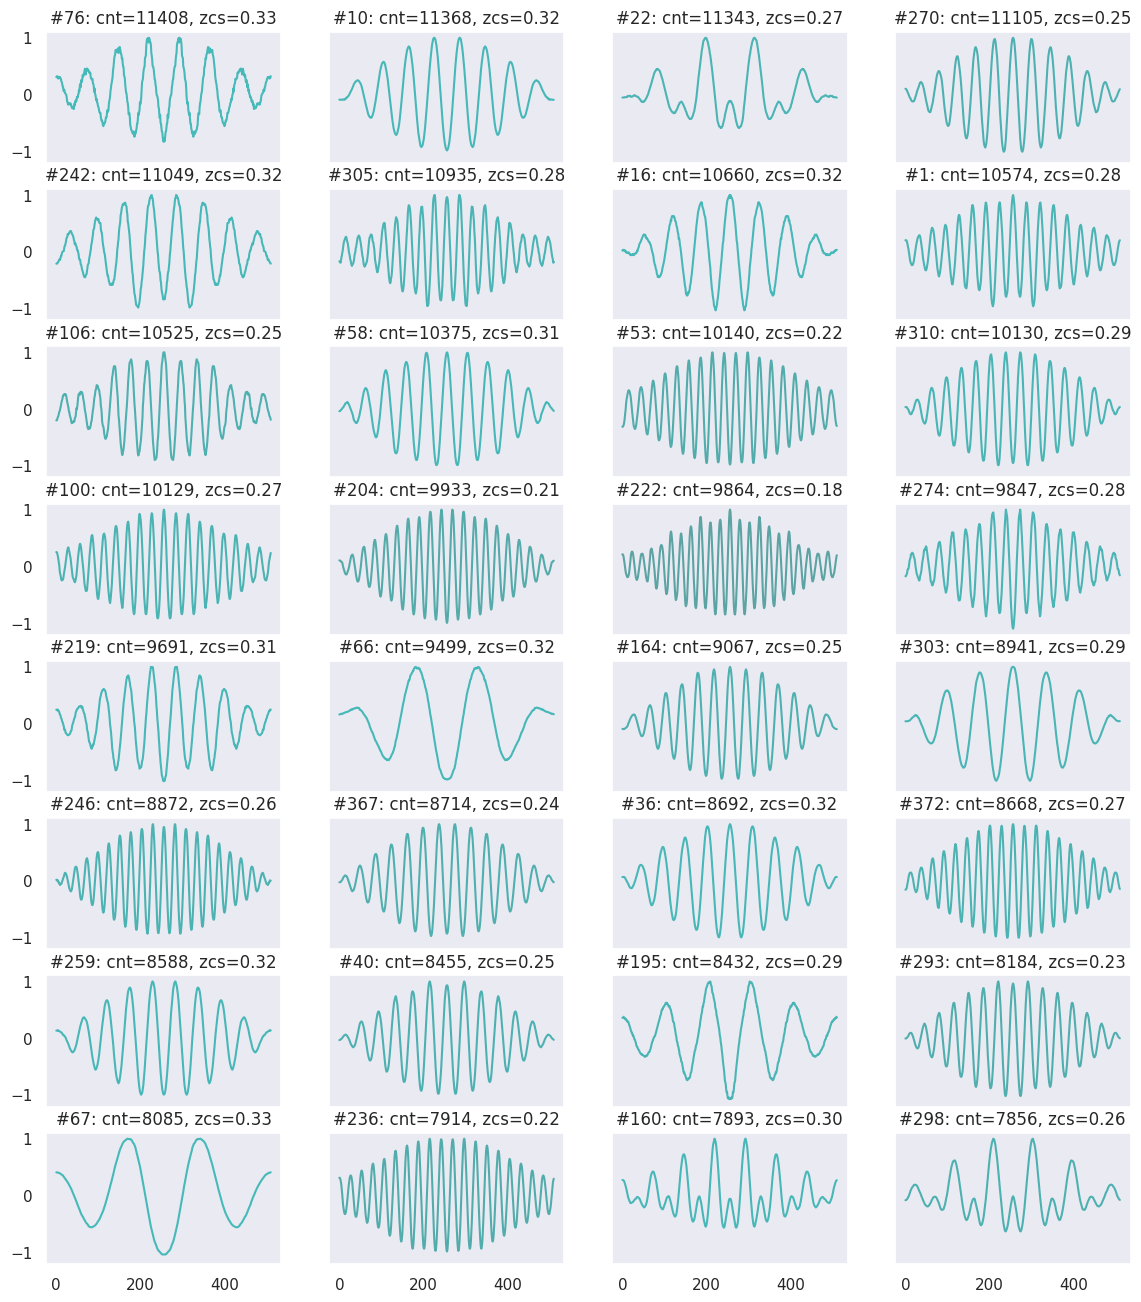

In [40]:
top_counter = tokens_counter.most_common(64)
fig, axes = plt.subplots(8, 4, figsize=(14,16), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    idx, count = top_counter[32+i]
    ax.plot(emb[idx], color=emb_color[idx])
    ax.set_title(f'#{idx}: cnt={count}, zcs={zcs[idx]:.2f}')

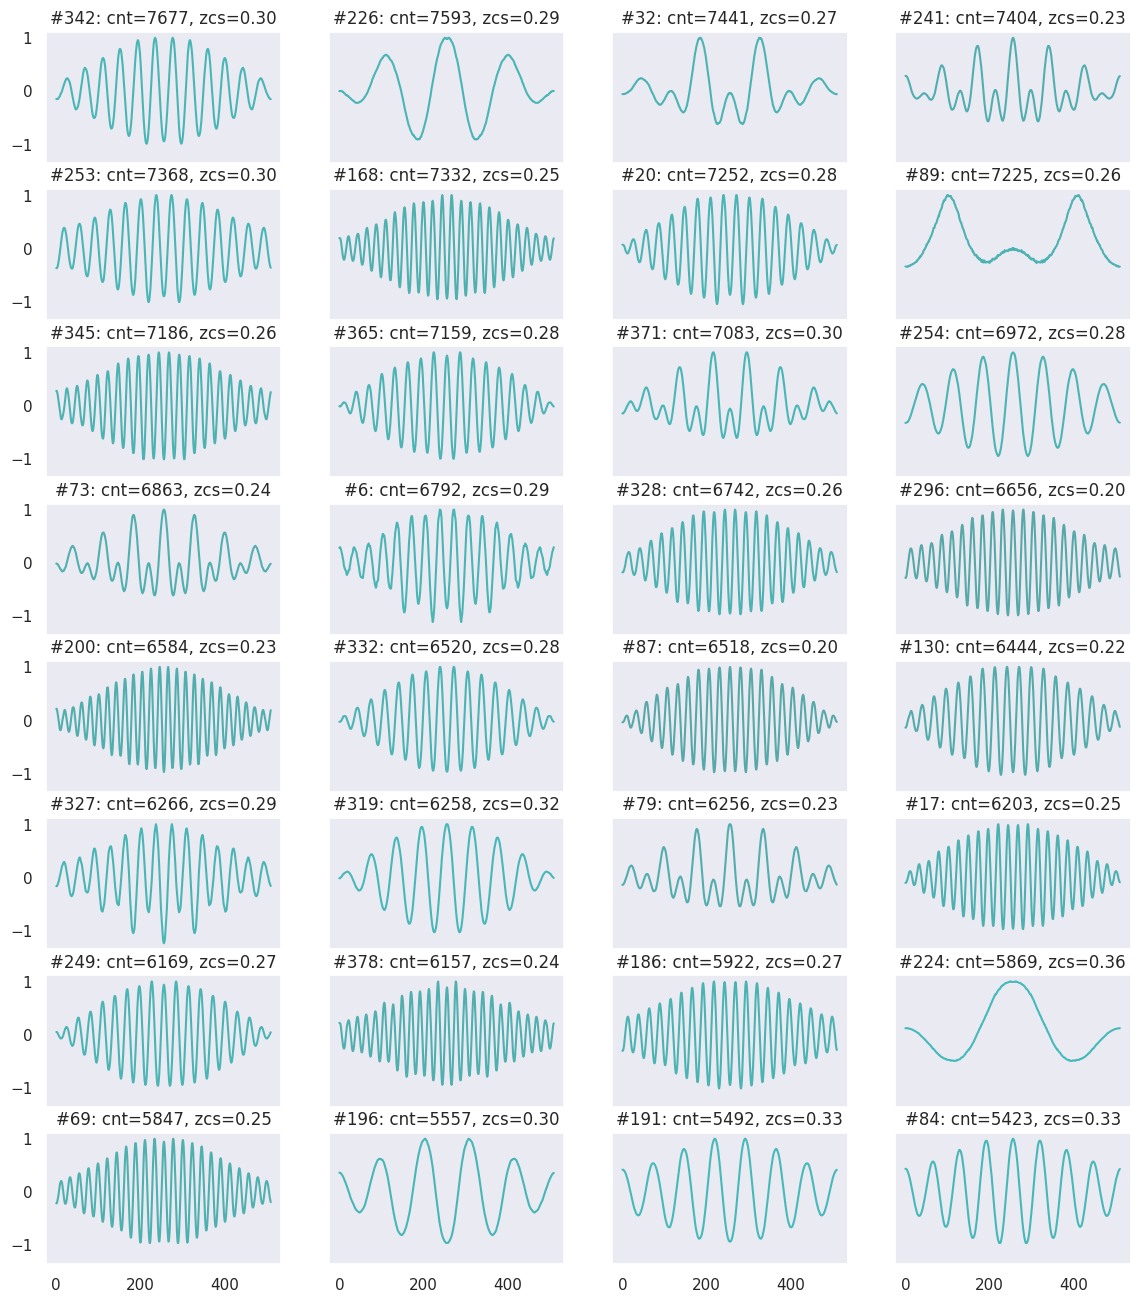

In [41]:
top_counter = tokens_counter.most_common(64+32)
fig, axes = plt.subplots(8, 4, figsize=(14,16), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    idx, count = top_counter[32+32+i]
    ax.plot(emb[idx], color=emb_color[idx])
    ax.set_title(f'#{idx}: cnt={count}, zcs={zcs[idx]:.2f}')

In [42]:
padded_tensors = torch.nn.utils.rnn.pad_sequence(
    [torch.tensor(d, dtype=torch.int) for d in data_x_tokens],
    batch_first=True, padding_value=-1)

In [43]:
padded_tensors.shape

torch.Size([4639, 1273])

In [44]:
np.save(f'{data_dir}{dataset_name}/preprocessing/{dataset_name}.tokens.npy', padded_tensors.numpy(), allow_pickle=True)

In [45]:
df['tokens'] = data_x_tokens

In [46]:
emo_tokens = {} 
emo_tokens_counter = {}
for e in np.unique(data_y):
    emo_tokens[e] = np.concatenate(df[df['emotion_key']==e]['tokens'].values)
    emo_tokens_counter[e] = Counter(emo_tokens[e])

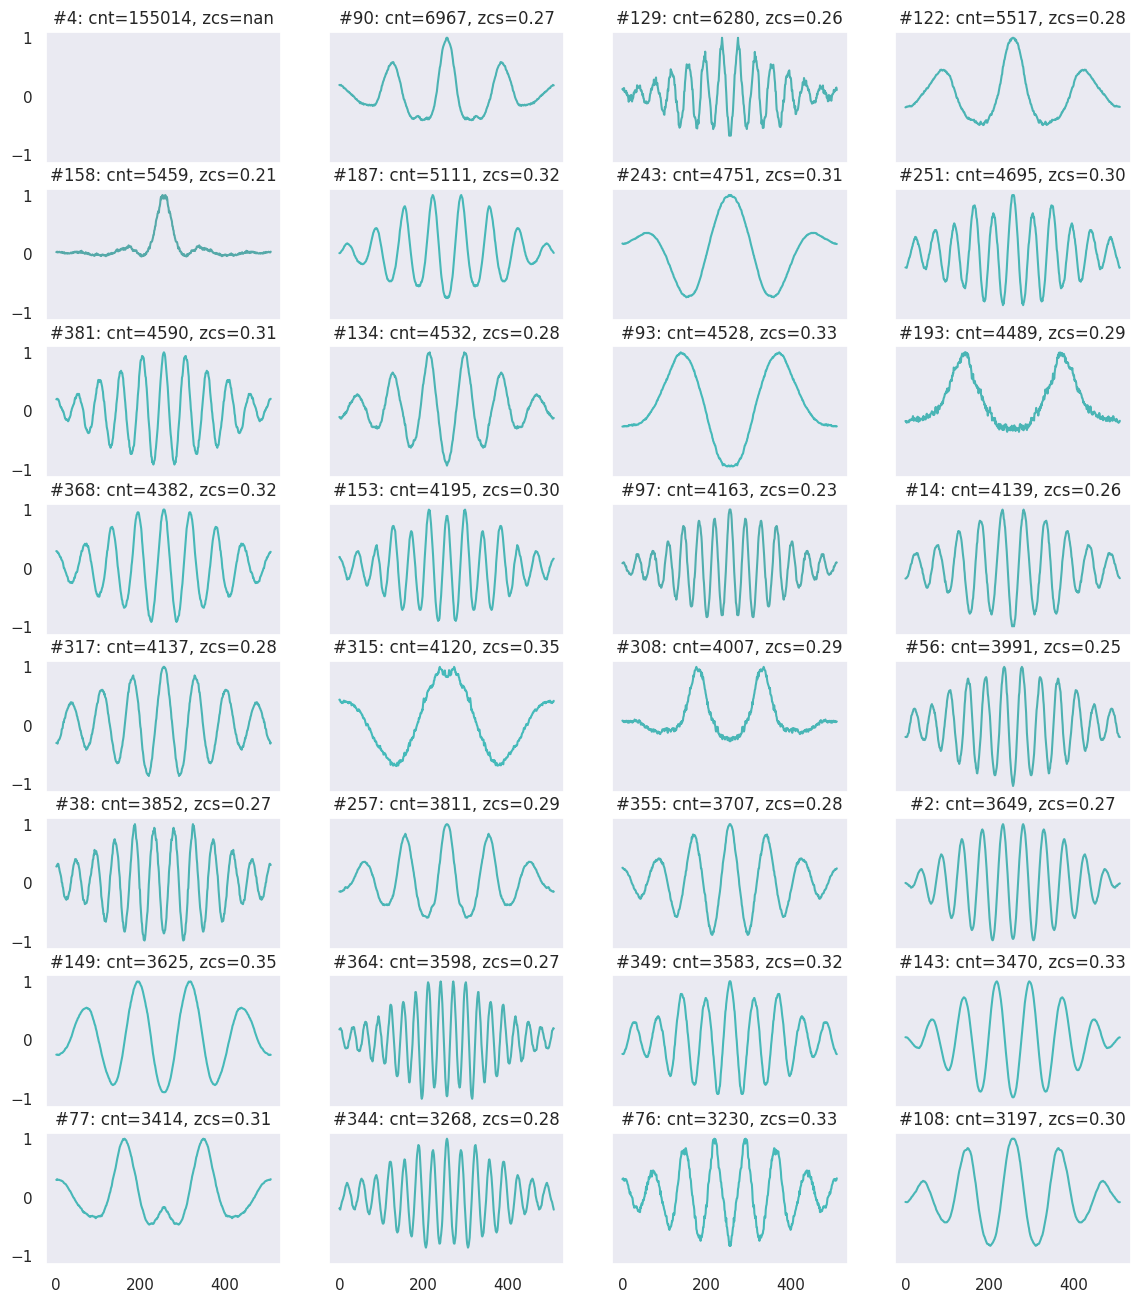

In [47]:
e_top_counter = emo_tokens_counter['hap'].most_common(32)
fig, axes = plt.subplots(8, 4, figsize=(14,16), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    idx, count = e_top_counter[i]
    ax.plot(emb[idx], color=emb_color[idx])
    ax.set_title(f'#{idx}: cnt={count}, zcs={zcs[idx]:.2f}')

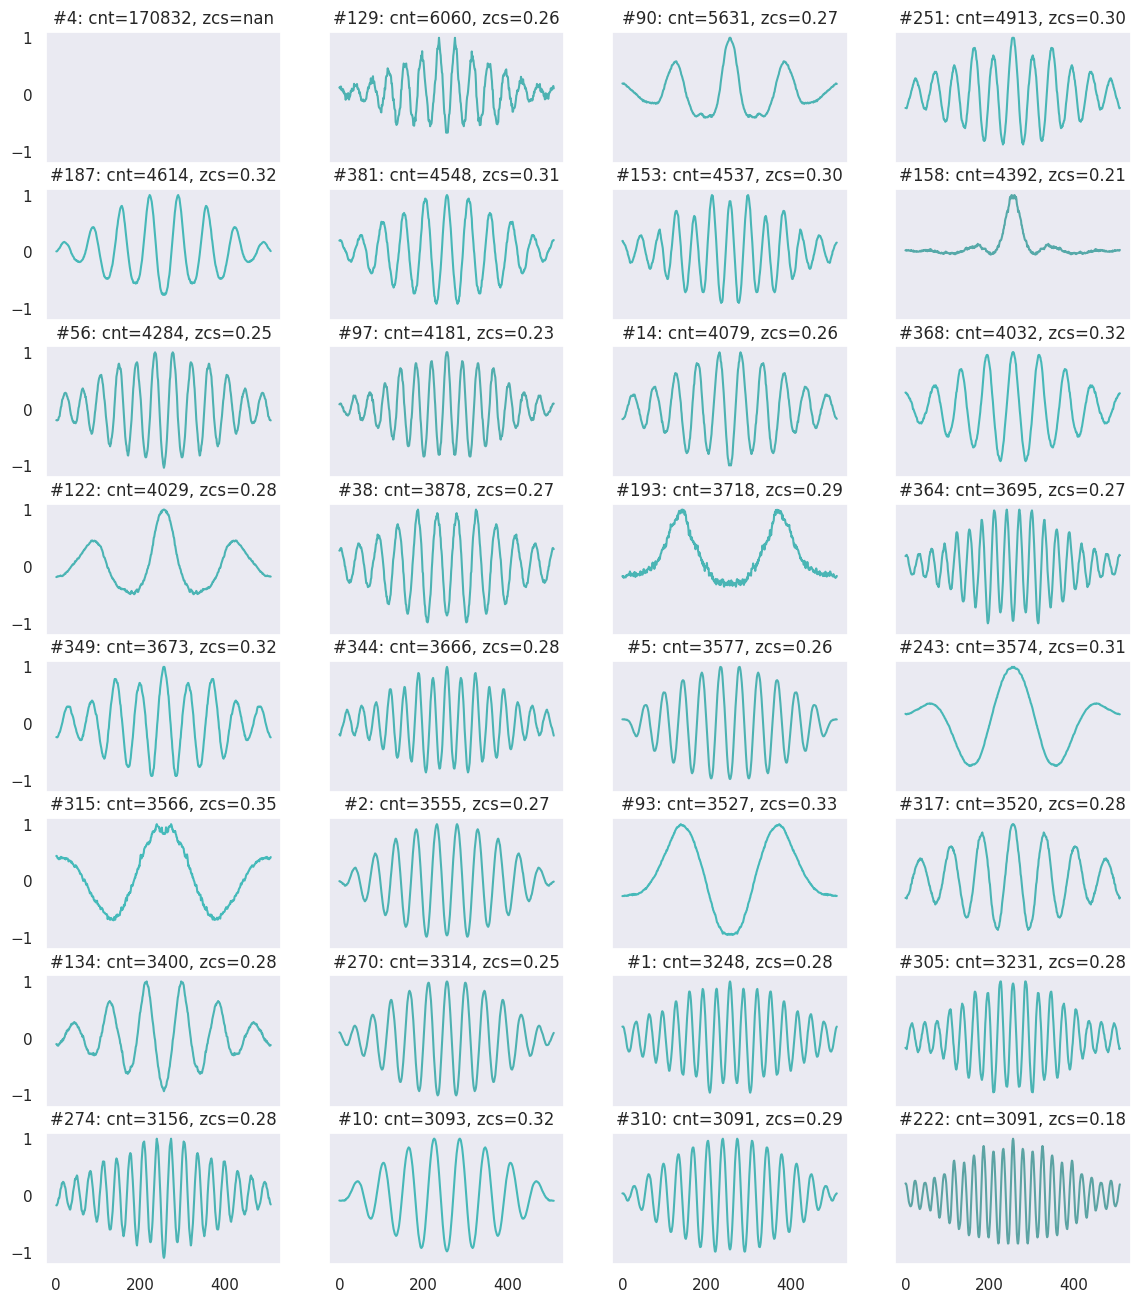

In [48]:
e_top_counter = emo_tokens_counter['ang'].most_common(32)
fig, axes = plt.subplots(8, 4, figsize=(14,16), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    idx, count = e_top_counter[i]
    ax.plot(emb[idx], color=emb_color[idx])
    ax.set_title(f'#{idx}: cnt={count}, zcs={zcs[idx]:.2f}')

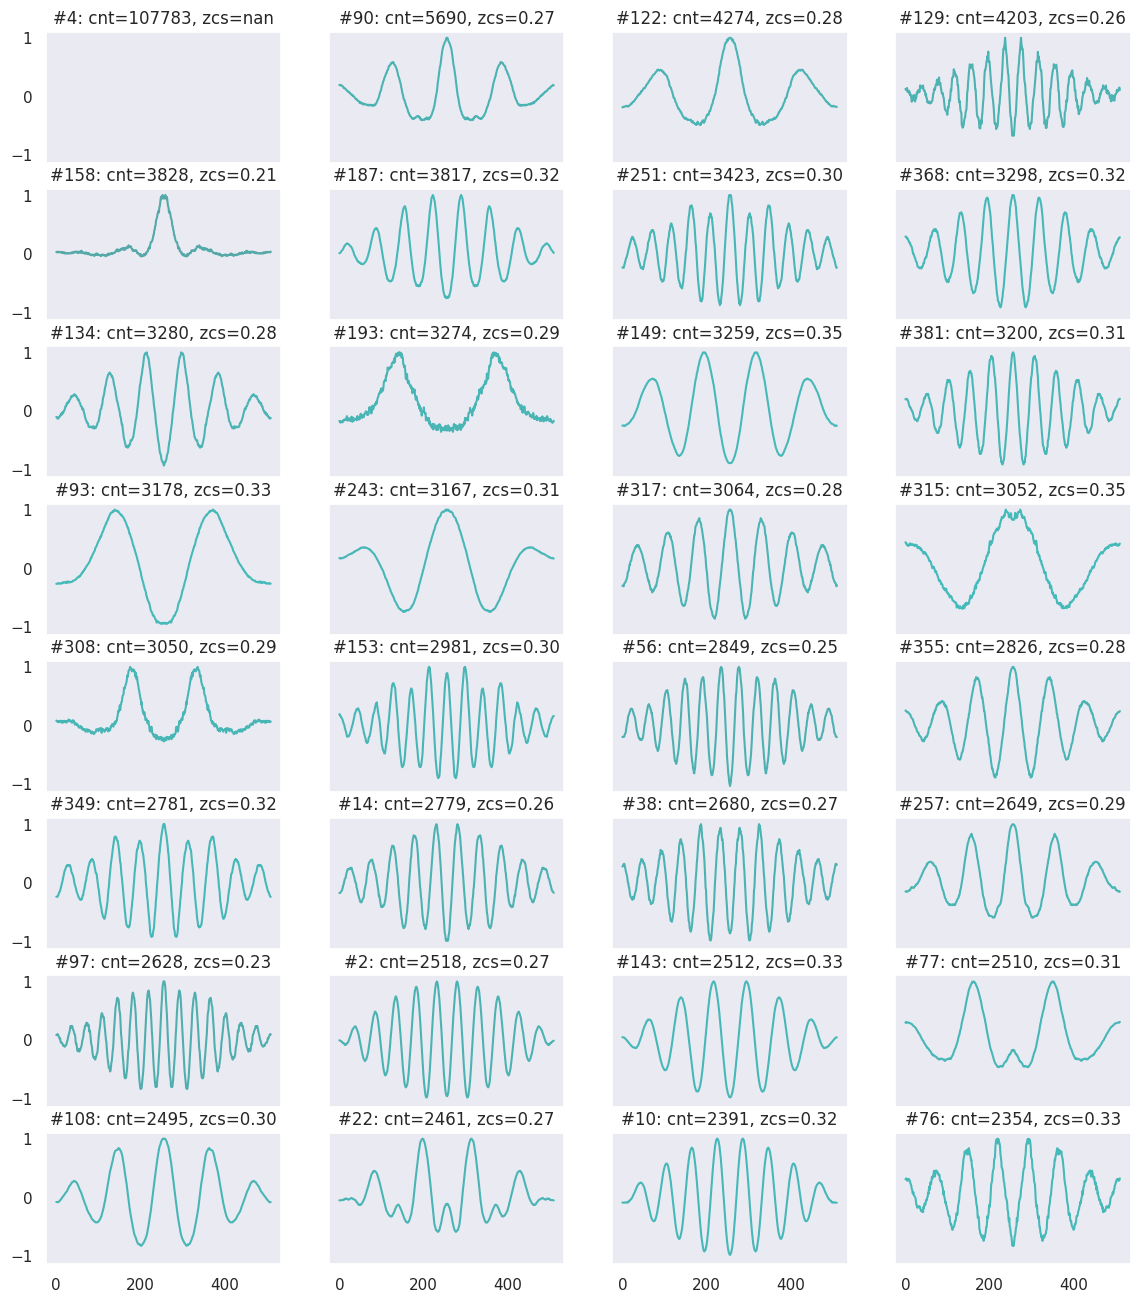

In [49]:
e_top_counter = emo_tokens_counter['sad'].most_common(32)
fig, axes = plt.subplots(8, 4, figsize=(14,16), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    idx, count = e_top_counter[i]
    ax.plot(emb[idx], color=emb_color[idx])
    ax.set_title(f'#{idx}: cnt={count}, zcs={zcs[idx]:.2f}')

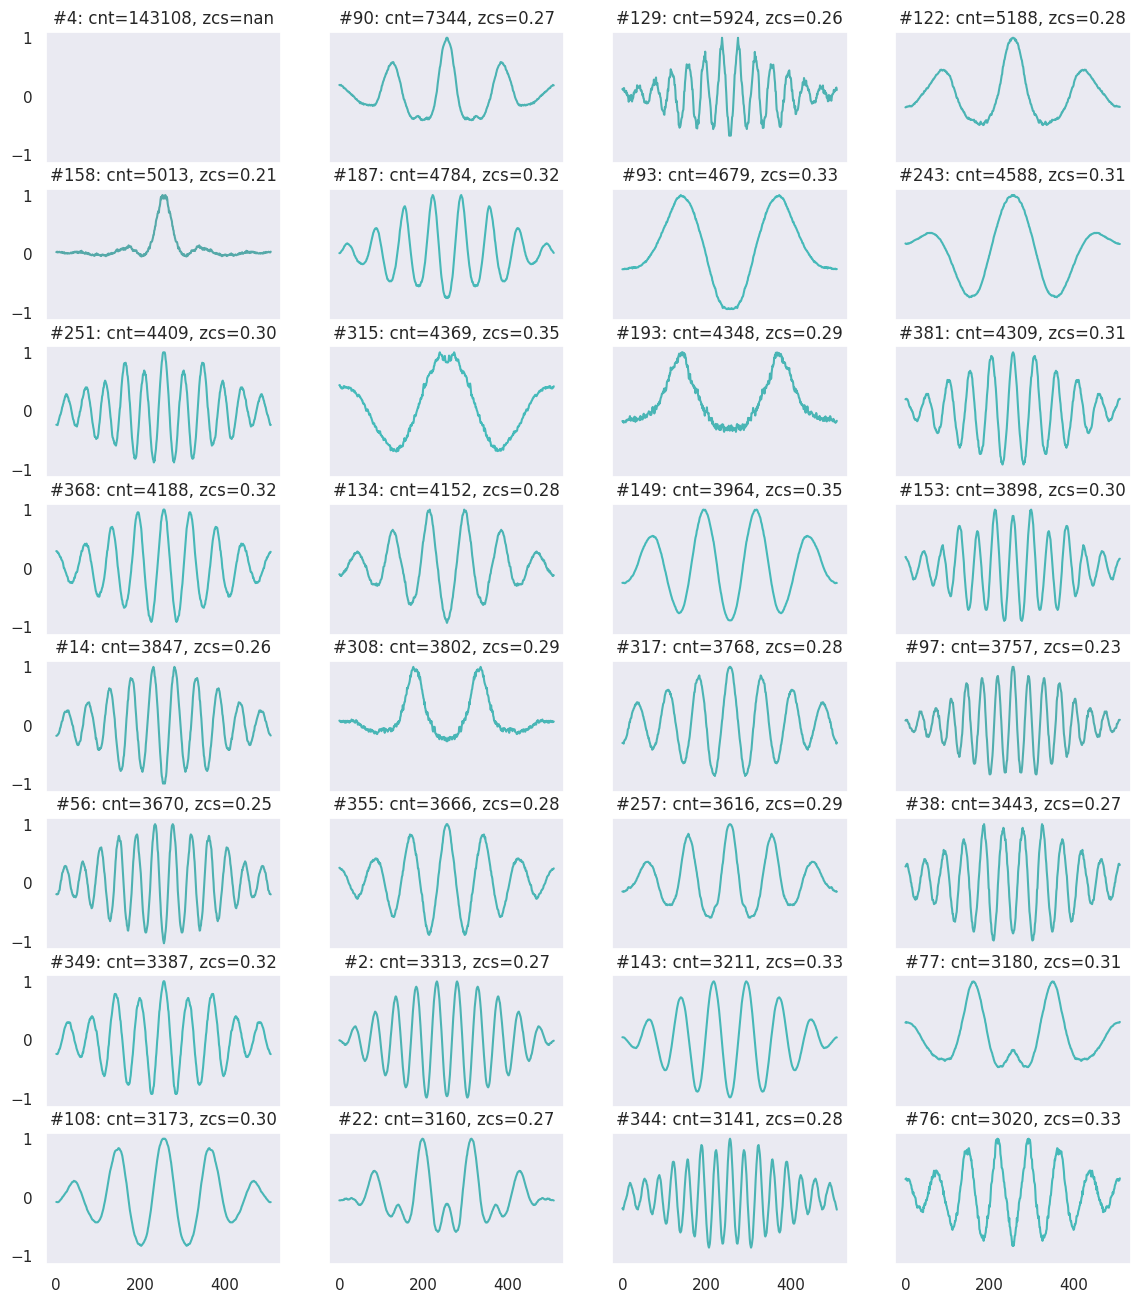

In [50]:
e_top_counter = emo_tokens_counter['neu'].most_common(32)
fig, axes = plt.subplots(8, 4, figsize=(14,16), sharex=True, sharey=True)
axes = axes.ravel()
for i, ax in enumerate(axes):
    idx, count = e_top_counter[i]
    ax.plot(emb[idx], color=emb_color[idx])
    ax.set_title(f'#{idx}: cnt={count}, zcs={zcs[idx]:.2f}')

In [51]:
def token_count_vectorize(token_counter):
    vec = np.zeros(num_embeddings, dtype=int)
    for t in token_counter:
        vec[t] = token_counter[t]
    return vec

In [52]:
df['token_counter'] = df['tokens'].apply(lambda x: Counter(x))
df['token_count_vector'] = df['token_counter'].apply(lambda x: token_count_vectorize(x))

In [23]:
target_labels = ['ang', 'neu', 'sad', 'hap']
target_labels_color_name = ['red', 'yellow', 'blue', 'green']
target_labels_color = [(0.8,0.2,0.2), (0.8,0.8,0.2), (0.2,0.5,0.8), (0.2,0.8,0.5)]

In [54]:
data_x_token_count_vector = df[df['emotion_key'].isin(target_labels)]['token_count_vector'].values
np.hstack(data_x_token_count_vector).T.shape

(1781376,)

In [30]:
data_y_4emo = df[df['emotion_key'].isin(target_labels)]['emotion_key'].values
data_y_color = [target_labels_color[target_labels.index(label)] for label in data_y_4emo]
data_y_4emo_encoded = torch.tensor([target_labels.index(label) for label in data_y_4emo], dtype=torch.long)

In [58]:
data_x_token_count_vector = np.vstack(data_x_token_count_vector)
data_x_token_count_vector.shape

(4639, 384)

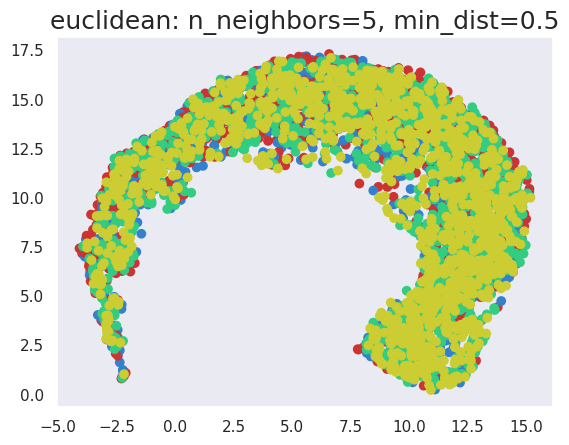

In [59]:
k = 5
min_dist = 0.5
umap_metric = 'euclidean'
visualize_embedding_umap(data_x_token_count_vector, colors=data_y_color, edgecolors=None,
          n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
          title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

/opt/anaconda3/envs/audio/lib/python3.9/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/opt/anaconda3/envs/audio/lib/python3.9/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


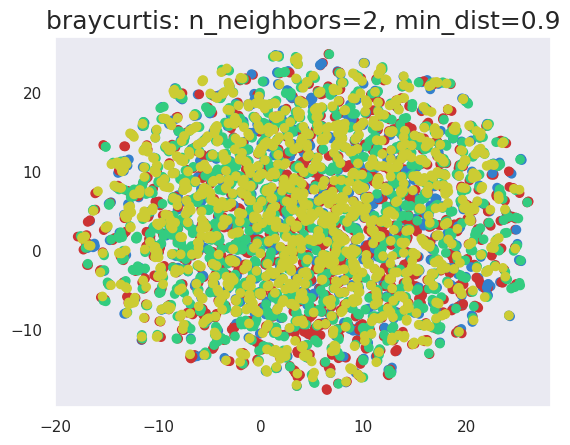

In [60]:
k = 2
min_dist = 0.9
umap_metric = 'braycurtis'
visualize_embedding_umap(data_x_token_count_vector, colors=data_y_color, edgecolors=None,
          n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
          title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

In [20]:
from IConNet.acov.visualize import (
    train_and_visualize_embedding_umap, transform_and_visualize_umap
)

(UMAP(learning_rate=0.001, min_dist=0.3, n_epochs=500, n_neighbors=30, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}),
 array([[6.799668 , 6.227653 ],
        [6.5729504, 7.345465 ],
        [8.89376  , 7.8276753],
        ...,
        [4.4017153, 8.66472  ],
        [9.165396 , 6.401046 ],
        [9.868097 , 4.618364 ]], dtype=float32))

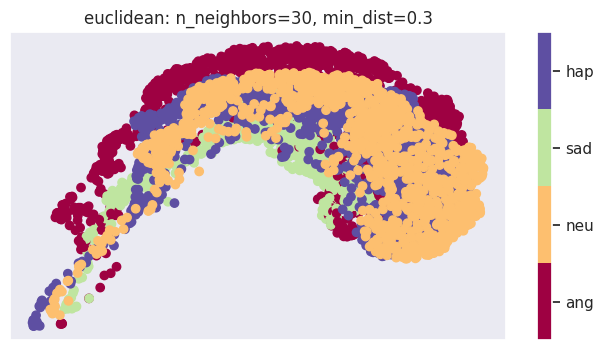

In [62]:
k = 30
min_dist = 0.3
umap_metric = 'euclidean'
train_and_visualize_embedding_umap(
    data_x_token_count_vector, 
    target=data_y_4emo_encoded, classnames=target_labels, 
    edgecolors=None, n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

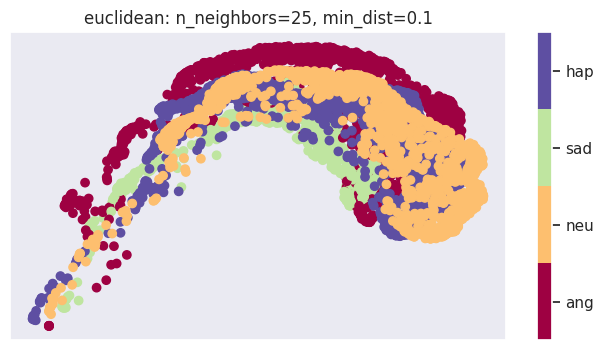

In [63]:
k = 25
min_dist = 0.1
umap_metric = 'euclidean'
_, _ = train_and_visualize_embedding_umap(
    data_x_token_count_vector, 
    target=data_y_4emo_encoded, classnames=target_labels, 
    edgecolors=None, n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

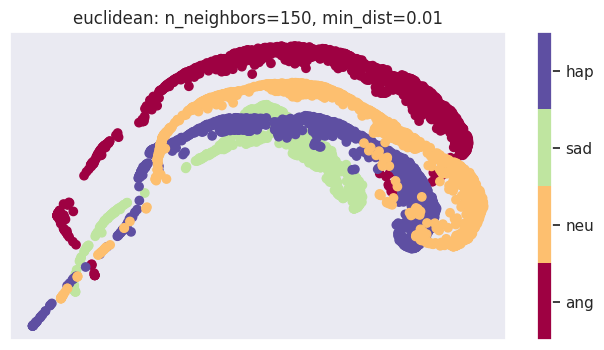

In [66]:
k = 150
min_dist = 0.01
umap_metric = 'euclidean'
_, _ = train_and_visualize_embedding_umap(
    data_x_token_count_vector, 
    target=data_y_4emo_encoded, classnames=target_labels, 
    edgecolors=None, n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

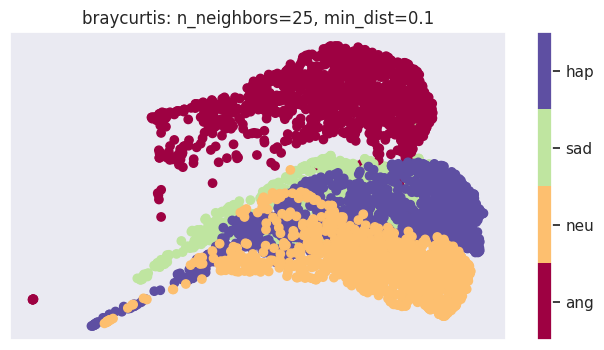

In [64]:
k = 25
min_dist = 0.1
umap_metric = 'braycurtis'
_, _ = train_and_visualize_embedding_umap(
    data_x_token_count_vector, 
    target=data_y_4emo_encoded, classnames=target_labels, 
    edgecolors=None, n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

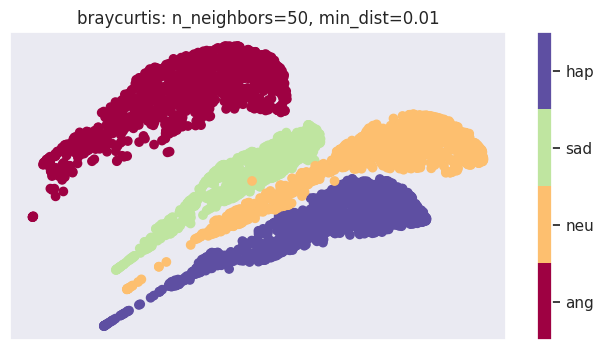

In [65]:
k = 50
min_dist = 0.01
umap_metric = 'braycurtis'
_, _ = train_and_visualize_embedding_umap(
    data_x_token_count_vector, 
    target=data_y_4emo_encoded, classnames=target_labels, 
    edgecolors=None, n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

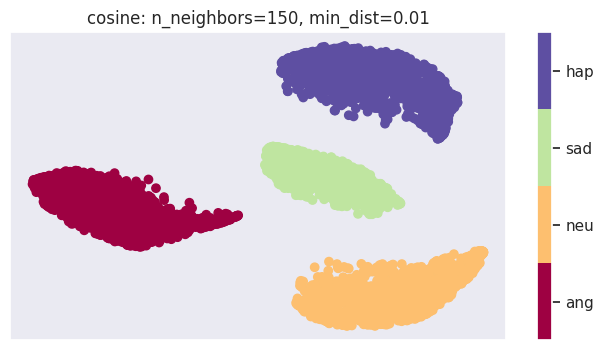

In [68]:
k = 150
min_dist = 0.01
umap_metric = 'cosine'
transformer, x_train_transformed = train_and_visualize_embedding_umap(
    data_x_token_count_vector, 
    target=data_y_4emo_encoded, classnames=target_labels, 
    edgecolors=None, n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

In [21]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA, FastICA
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [71]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x_token_count_vector, data_y_4emo_encoded, test_size=0.2, 
    random_state=42, stratify=data_y_4emo_encoded)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

Train: 3711
Test: 928


In [73]:
x_train_norm = x_train / x_train.sum(axis=1, keepdims=True)
x_test_norm = x_test / x_test.sum(axis=1, keepdims=True)

In [101]:
scaler = StandardScaler().fit(x_train_norm)

In [102]:
x_train_norm_scaled = scaler.transform(x_train_norm)
x_test_norm_scaled = scaler.transform(x_test_norm)

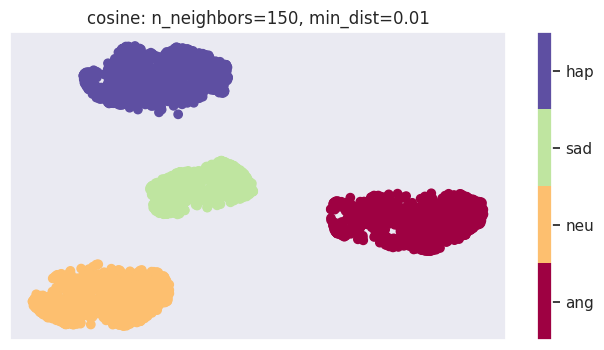

In [103]:
k = 150
min_dist = 0.01
umap_metric = 'cosine'
transformer, x_train_transformed = train_and_visualize_embedding_umap(
    x_train_norm_scaled, 
    target=y_train, classnames=target_labels, 
    edgecolors=None, n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

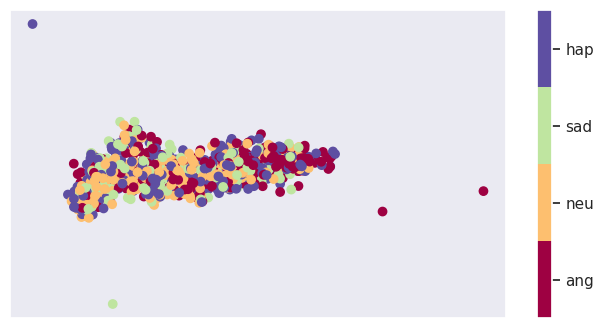

In [104]:
x_test_transformed = transform_and_visualize_umap(transformer, x_test_norm_scaled, y_test, target_labels)

              precision    recall  f1-score   support

           0       0.51      0.26      0.34       258
           1       0.00      0.00      0.00       248
           2       0.18      0.89      0.30       161
           3       1.00      0.00      0.01       261

    accuracy                           0.23       928
   macro avg       0.42      0.29      0.16       928
weighted avg       0.45      0.23      0.15       928

[[ 66   0 192   0]
 [ 14   0 234   0]
 [ 16   1 144   0]
 [ 33   0 227   1]]


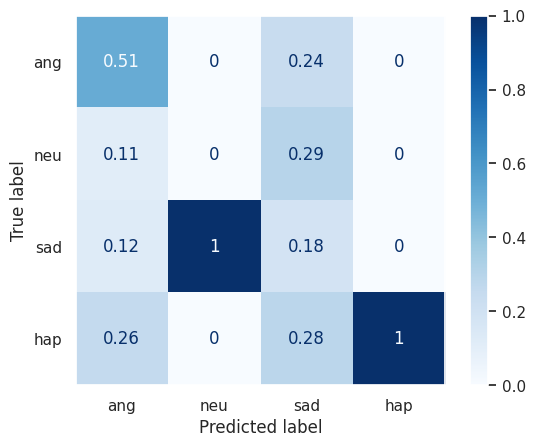

In [105]:
cls = SVC(C=100000, max_iter=20000)
cls = cls.fit(x_train_transformed, y_train)
y_test_pred = cls.predict(x_test_transformed)
print(classification_report(y_true=y_test, y_pred=y_test_pred))
print(confusion_matrix(y_true=y_test, y_pred=y_test_pred))
disp = ConfusionMatrixDisplay.from_predictions(
        y_true=y_test, y_pred=y_test_pred,
        display_labels=target_labels,
        cmap=plt.cm.Blues,
        normalize='pred',
    )

In [24]:
def train_skmodel(model, x_train, y_train, x_test, y_test, classnames=target_labels):
    model = model.fit(x_train, y_train)
    y_test_pred = model.predict(x_test)
    print(classification_report(y_true=y_test, y_pred=y_test_pred))
    print(confusion_matrix(y_true=y_test, y_pred=y_test_pred))
    disp = ConfusionMatrixDisplay.from_predictions(
            y_true=y_test, y_pred=y_test_pred,
            display_labels=classnames,
            cmap=plt.cm.Blues,
            normalize='pred',
        )

In [107]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=1, penalty="l1", dual=False, max_iter=10000).fit(
    x_train_norm_scaled, y_train)

              precision    recall  f1-score   support

           0       0.41      0.46      0.44       258
           1       0.29      0.29      0.29       248
           2       0.25      0.20      0.22       161
           3       0.34      0.33      0.33       261

    accuracy                           0.34       928
   macro avg       0.32      0.32      0.32       928
weighted avg       0.33      0.34      0.33       928

[[119  52  33  54]
 [ 66  73  34  75]
 [ 41  45  32  43]
 [ 62  84  28  87]]


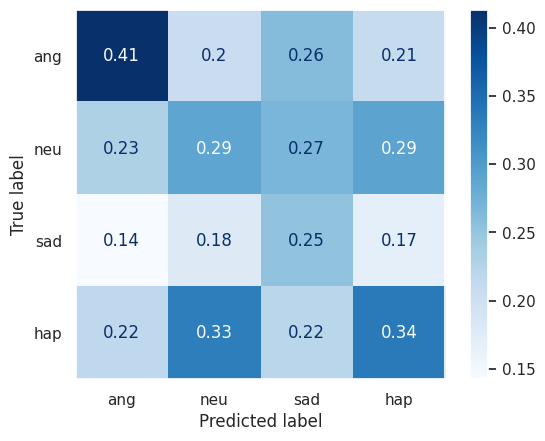

In [108]:
feat_select_trans = SelectFromModel(lsvc, prefit=True)
x_train_reduced = feat_select_trans.transform(x_train_norm_scaled)
x_test_reduced = feat_select_trans.transform(x_test_norm_scaled)
cls = SVC(C=10000, max_iter=20000)
train_skmodel(cls, x_train_reduced, y_train, x_test_reduced, y_test)

In [109]:
x_train_reduced.shape

(3711, 311)

              precision    recall  f1-score   support

           0       0.35      0.40      0.37       258
           1       0.30      0.30      0.30       248
           2       0.18      0.16      0.17       161
           3       0.28      0.26      0.27       261

    accuracy                           0.29       928
   macro avg       0.28      0.28      0.28       928
weighted avg       0.29      0.29      0.29       928

[[102  50  36  70]
 [ 67  74  43  64]
 [ 45  47  26  43]
 [ 76  76  41  68]]


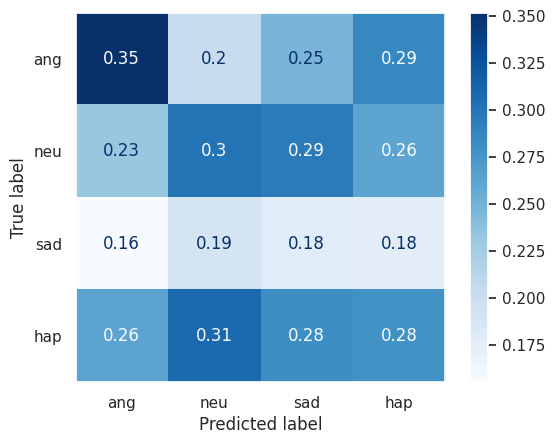

In [110]:
pca = PCA(n_components=64, whiten=False)
pca = pca.fit(x_train_norm_scaled)
x_train_reduced = pca.transform(x_train_norm_scaled)
x_test_reduced = pca.transform(x_test_norm_scaled)
cls = SVC(C=10000, max_iter=20000)
train_skmodel(cls, x_train_reduced, y_train, x_test_reduced, y_test)

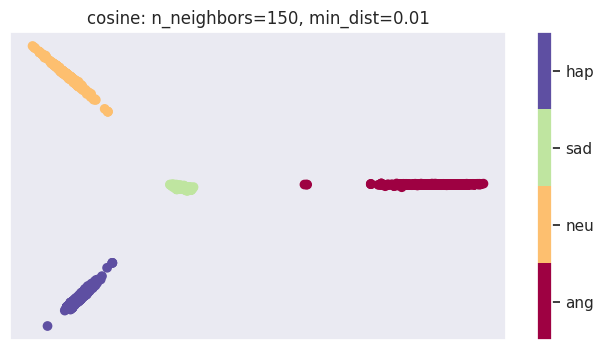

In [116]:
pca = FastICA(
    n_components=64, fun='exp', max_iter=1000, random_state=42)
pca = pca.fit(x_train_norm_scaled)
transformer, x_train_transformed = train_and_visualize_embedding_umap(
    pca.transform(x_train_norm_scaled), 
    target=y_train, classnames=target_labels, n_components=32,
    edgecolors=None, n_neighbors=k, min_dist=min_dist, metric=umap_metric, 
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}')

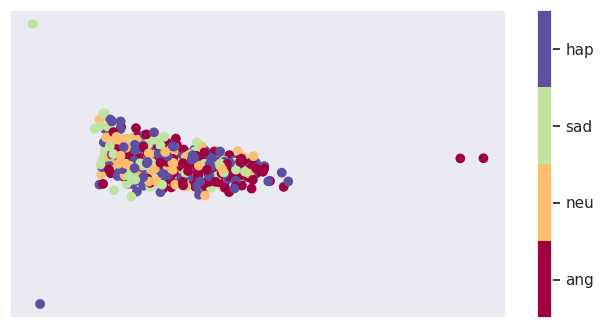

In [117]:
x_test_reduced = transform_and_visualize_umap(
    transformer, pca.transform(x_test_norm_scaled), y_test, target_labels)

              precision    recall  f1-score   support

           0       0.40      0.43      0.42       258
           1       0.34      0.41      0.37       248
           2       0.15      0.07      0.09       161
           3       0.29      0.31      0.30       261

    accuracy                           0.33       928
   macro avg       0.30      0.31      0.30       928
weighted avg       0.31      0.33      0.32       928

[[112  62  18  66]
 [ 45 102  23  78]
 [ 42  55  11  53]
 [ 79  82  19  81]]


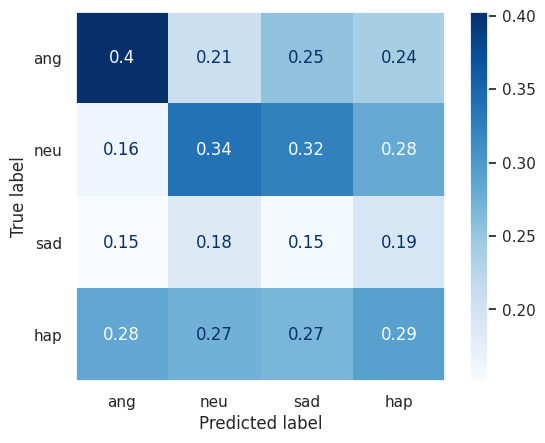

In [118]:
cls = SVC(C=100000, max_iter=20000)
train_skmodel(cls, x_train_transformed, y_train, x_test_reduced, y_test)

              precision    recall  f1-score   support

           0       0.41      0.48      0.44       258
           1       0.32      0.44      0.37       248
           2       0.11      0.02      0.03       161
           3       0.29      0.29      0.29       261

    accuracy                           0.34       928
   macro avg       0.28      0.31      0.28       928
weighted avg       0.30      0.34      0.31       928

[[124  63   9  62]
 [ 50 109  11  78]
 [ 46  66   3  46]
 [ 84  98   4  75]]


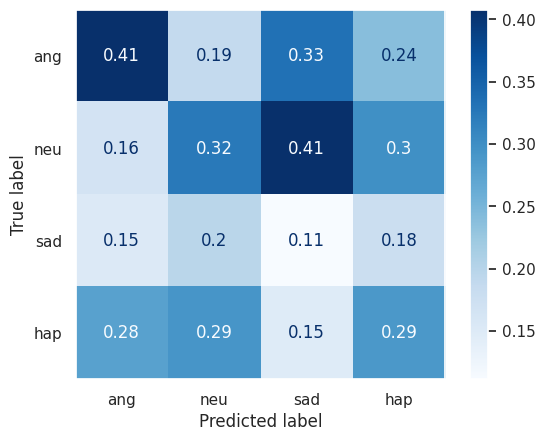

In [120]:
cls = MLPClassifier((500, 500), 
                   batch_size=64, learning_rate='adaptive', 
                    learning_rate_init=0.0001, max_iter=10000, shuffle=True, 
                    random_state=42, momentum=0.9, nesterovs_momentum=True, 
                    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,)
train_skmodel(cls, x_train_transformed, y_train, x_test_reduced, y_test)

              precision    recall  f1-score   support

           0       0.41      0.47      0.43       258
           1       0.34      0.54      0.41       248
           2       0.21      0.02      0.03       161
           3       0.31      0.27      0.29       261

    accuracy                           0.35       928
   macro avg       0.32      0.32      0.29       928
weighted avg       0.33      0.35      0.32       928

[[120  81   5  52]
 [ 50 133   4  61]
 [ 44  72   3  42]
 [ 82 107   2  70]]


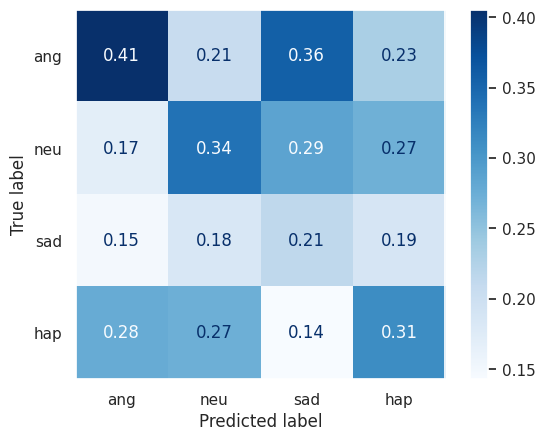

In [121]:
cls = KNeighborsClassifier(n_neighbors=10, metric='minkowski')
train_skmodel(cls, x_train_transformed, y_train, x_test_reduced, y_test)

              precision    recall  f1-score   support

           0       0.41      0.48      0.44       258
           1       0.34      0.61      0.44       248
           2       0.15      0.02      0.03       161
           3       0.34      0.21      0.26       261

    accuracy                           0.36       928
   macro avg       0.31      0.33      0.29       928
weighted avg       0.33      0.36      0.32       928

[[124  90   6  38]
 [ 53 152   7  36]
 [ 42  86   3  30]
 [ 84 119   4  54]]


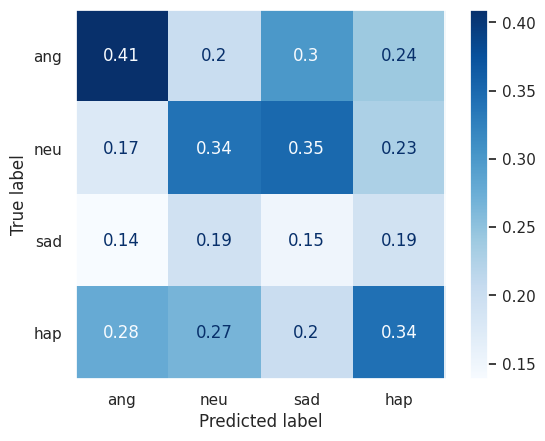

In [123]:
cls = KNeighborsClassifier(n_neighbors=3, metric='euclidean', algorithm='kd_tree', leaf_size=5)
train_skmodel(cls, x_train_transformed, y_train, x_test_reduced, y_test)

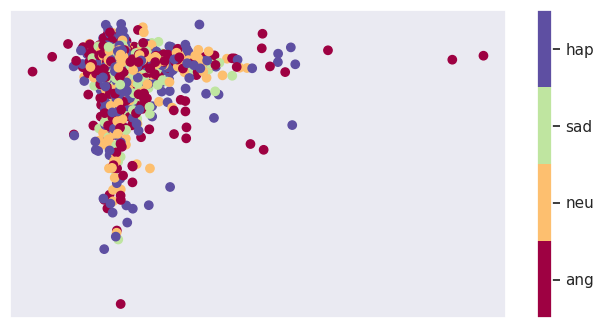

In [128]:
pca = FastICA(
    n_components=128, fun='logcosh', max_iter=1000, random_state=42)
pca = pca.fit(x_train_norm_scaled)
x_train_reduced = transform_and_visualize_umap(pca, x_train_norm_scaled, y_train, target_labels)

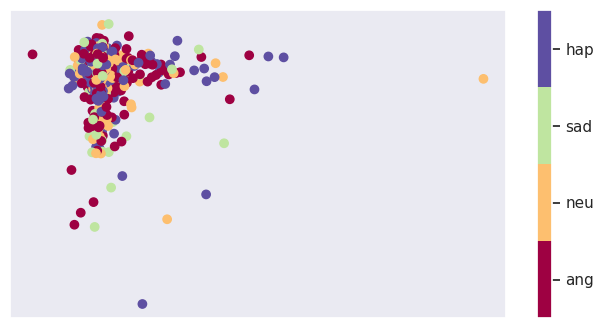

In [129]:
x_test_reduced = transform_and_visualize_umap(pca, x_test_norm_scaled, y_test, target_labels)

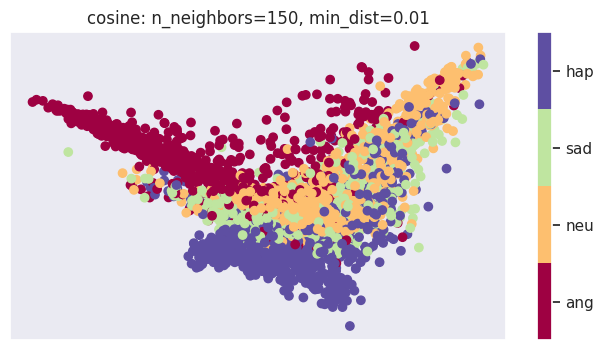

In [132]:
k = 150
min_dist = 0.01
umap_metric = 'cosine'

transformer, x_train_transformed = train_and_visualize_embedding_umap(
    x_train_norm_scaled, 
    target=y_train, 
    classnames=target_labels,
    mask_ratio=0.1,
    n_components=64,
    edgecolors=None,
    n_neighbors=k, min_dist=min_dist, metric=umap_metric,
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}'
)

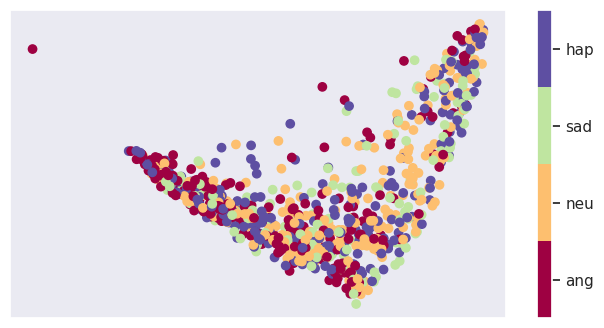

In [133]:
x_test_transformed = transform_and_visualize_umap(
    transformer, x_test_norm_scaled, y_test, target_labels)

              precision    recall  f1-score   support

           0       0.40      0.50      0.45       258
           1       0.33      0.75      0.45       248
           2       0.49      0.11      0.17       161
           3       1.00      0.00      0.01       261

    accuracy                           0.36       928
   macro avg       0.55      0.34      0.27       928
weighted avg       0.57      0.36      0.28       928

[[130 123   5   0]
 [ 57 186   5   0]
 [ 42 102  17   0]
 [ 92 160   8   1]]


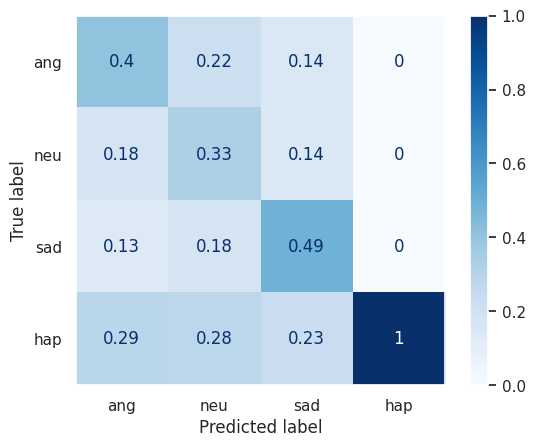

In [134]:
cls = MLPClassifier((500, 500), 
                   batch_size=64, learning_rate='adaptive', 
                    learning_rate_init=0.0001, max_iter=10000, shuffle=True, 
                    random_state=42, momentum=0.9, nesterovs_momentum=True, 
                    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,)
train_skmodel(cls, x_train_transformed, y_train, x_test_transformed, y_test)

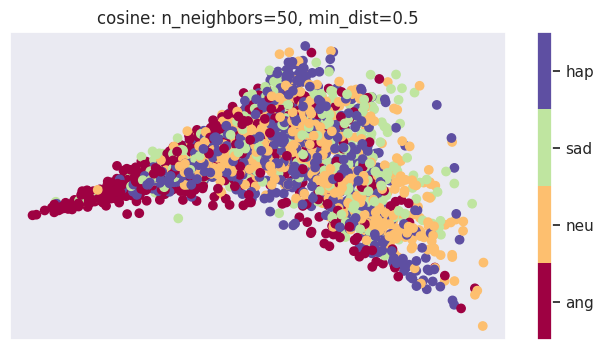

In [135]:
k = 50
min_dist = 0.5
umap_metric = 'cosine'

transformer, x_train_transformed = train_and_visualize_embedding_umap(
    x_train_norm_scaled, 
    target=y_train, 
    classnames=target_labels,
    mask_ratio=0.15,
    n_components=128,
    edgecolors=None,
    n_neighbors=k, min_dist=min_dist, metric=umap_metric,
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}'
)

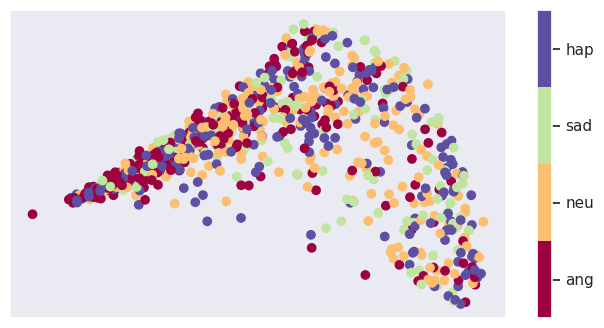

In [136]:
x_test_transformed = transform_and_visualize_umap(
    transformer, x_test_norm_scaled, y_test, target_labels)

              precision    recall  f1-score   support

           0       0.38      0.49      0.42       258
           1       0.29      0.17      0.21       248
           2       0.25      0.42      0.32       161
           3       0.29      0.20      0.23       261

    accuracy                           0.31       928
   macro avg       0.30      0.32      0.30       928
weighted avg       0.31      0.31      0.30       928

[[126  40  43  49]
 [ 73  42  87  46]
 [ 43  20  68  30]
 [ 93  45  72  51]]


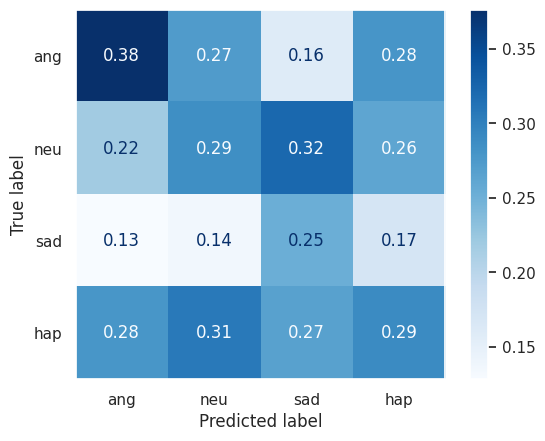

In [137]:
cls = MLPClassifier((500, 500), 
                   batch_size=64, learning_rate='adaptive', 
                    learning_rate_init=0.0001, max_iter=10000, shuffle=True, 
                    random_state=42, momentum=0.9, nesterovs_momentum=True, 
                    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,)
train_skmodel(cls, x_train_transformed, y_train, x_test_transformed, y_test)

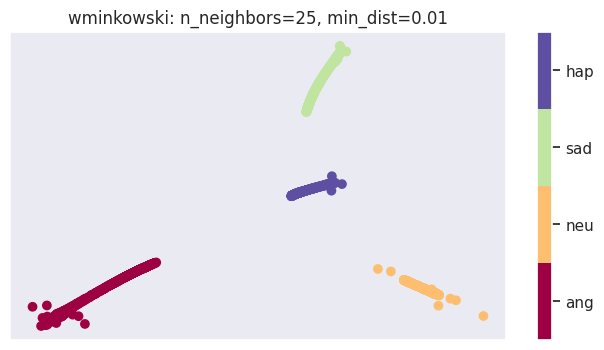

In [138]:
k = 25
min_dist = 0.01
umap_metric = 'wminkowski'

transformer4, x_train_transformed4 = train_and_visualize_embedding_umap(
    x_train_norm_scaled, 
    target=y_train, 
    classnames=target_labels,
    n_components=32,
    edgecolors=None,
    n_neighbors=k, min_dist=min_dist, metric=umap_metric,
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}'
)

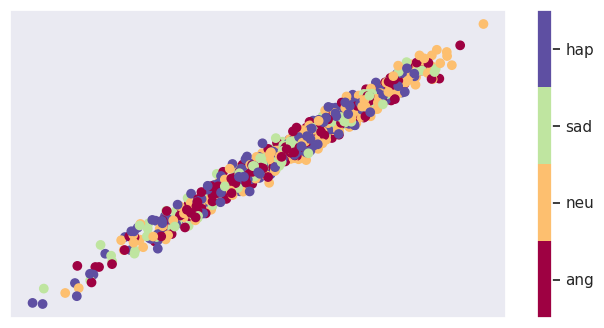

In [139]:
x_test_transformed4 = transform_and_visualize_umap(
    transformer4, x_test_norm_scaled, y_test, target_labels)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       258
           1       0.00      0.00      0.00       248
           2       0.00      0.00      0.00       161
           3       0.28      1.00      0.44       261

    accuracy                           0.28       928
   macro avg       0.07      0.25      0.11       928
weighted avg       0.08      0.28      0.12       928

[[  0   0   0 258]
 [  0   0   0 248]
 [  0   0   0 161]
 [  0   0   0 261]]


/opt/anaconda3/envs/audio/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/audio/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/audio/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


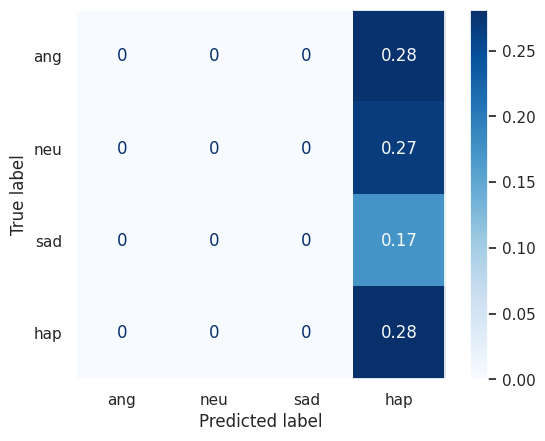

In [140]:
cls = MLPClassifier((500, 500), 
                   batch_size=64, learning_rate='adaptive', 
                    learning_rate_init=0.0001, max_iter=10000, shuffle=True, 
                    random_state=42, momentum=0.9, nesterovs_momentum=True, 
                    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,)
train_skmodel(cls, x_train_transformed4, y_train, x_test_transformed4, y_test)

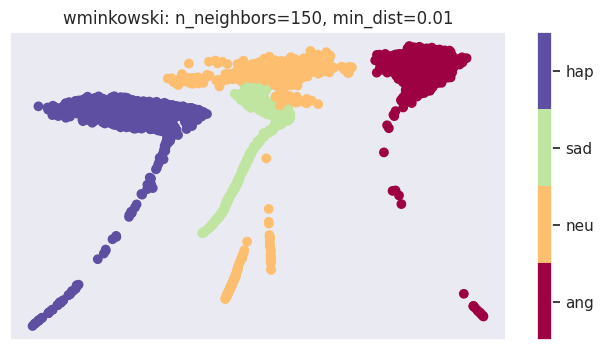

In [141]:
masked_class = 'neu'
mask_ratio = 0.9
n = sum(y_train==target_labels.index(masked_class))
masked_indices = np.random.choice(
    n, size=int(n*mask_ratio), replace=False)
final_masked_indices = torch.where(y_train==target_labels.index(masked_class),1,0).topk(k=n).indices[masked_indices]
masked_y_train = y_train.clone()
masked_y_train[final_masked_indices] = -1

k = 150
min_dist = 0.01
umap_metric = 'wminkowski'

transformer4, x_train_transformed4 = train_and_visualize_embedding_umap(
    x_train_norm_scaled, 
    target=y_train, masked_target=masked_y_train,
    classnames=target_labels,
    n_components=128,
    edgecolors=None,
    n_neighbors=k, min_dist=min_dist, metric=umap_metric,
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}'
)

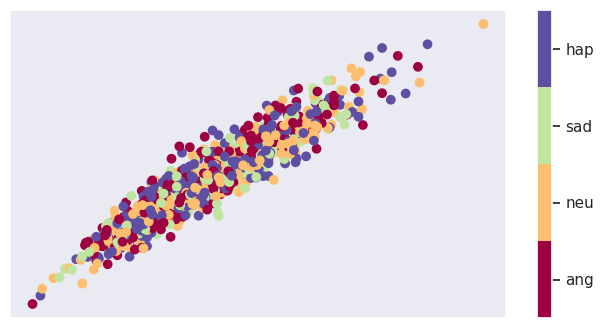

In [143]:
x_test_transformed4 = transform_and_visualize_umap(
    transformer4, x_test_norm_scaled, y_test, target_labels)

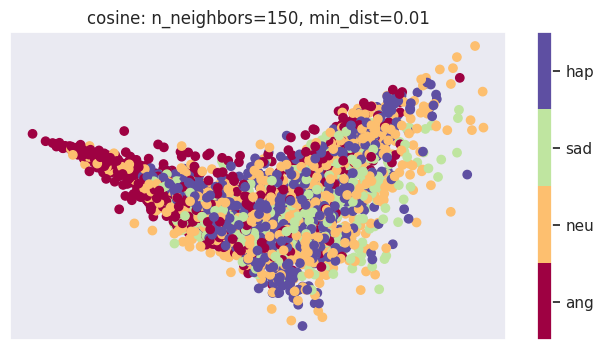

In [144]:
k = 150
min_dist = 0.01
umap_metric = 'cosine'

transformer4, x_train_transformed4 = train_and_visualize_embedding_umap(
    x_train_norm_scaled, 
    target=y_train, masked_target=masked_y_train,
    classnames=target_labels,
    n_components=128,
    edgecolors=None,
    n_neighbors=k, min_dist=min_dist, metric=umap_metric,
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}'
)

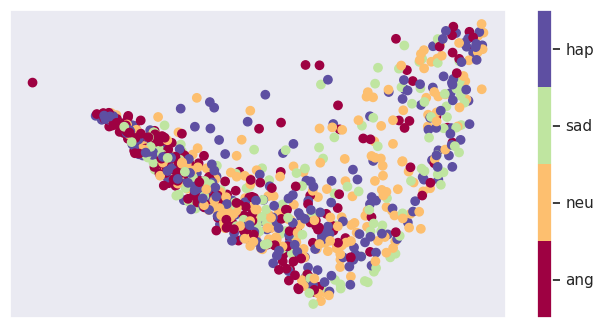

In [145]:
x_test_transformed4 = transform_and_visualize_umap(
    transformer4, x_test_norm_scaled, y_test, target_labels)

              precision    recall  f1-score   support

           0       1.00      0.01      0.02       258
           1       0.27      1.00      0.42       248
           2       0.00      0.00      0.00       161
           3       1.00      0.00      0.01       261

    accuracy                           0.27       928
   macro avg       0.57      0.25      0.11       928
weighted avg       0.63      0.27      0.12       928

[[  2 255   1   0]
 [  0 248   0   0]
 [  0 161   0   0]
 [  0 260   0   1]]


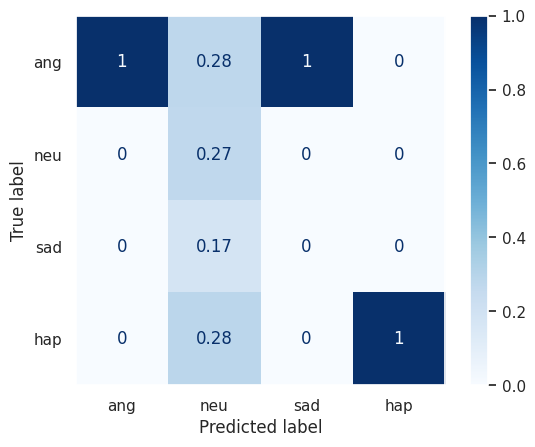

In [146]:
cls = MLPClassifier((500, 500), 
                   batch_size=64, learning_rate='adaptive', 
                    learning_rate_init=0.0001, max_iter=10000, shuffle=True, 
                    random_state=42, momentum=0.9, nesterovs_momentum=True, 
                    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,)
train_skmodel(cls, x_train_transformed4, y_train, x_test_transformed4, y_test)

In [147]:
df['token_count_vector'] = df['token_count_vector'].apply(np.squeeze)

In [149]:
df['token_count_vector_idf'] = df['token_count_vector'].apply(lambda x: np.clip(x, a_min=0, a_max=1))

In [150]:
token_idf = df['token_count_vector_idf'].values.sum(axis=-1)
print(sum(token_idf==0))
print(sum(token_idf>3000))
token_idf

73
34


array([1089, 2978, 3206, 1482, 4639, 3205, 2604,  826, 1009, 1854, 2863,
          0, 1483,   14, 3481,    0, 3139, 2511, 1626,  720, 2477, 1423,
       3021,  875,  596,    0,  818, 1245,    4, 1044, 1805, 1065, 2521,
       1246, 1361, 1767, 2722,    0, 3449, 1310, 2688, 1178,    0,  797,
          0, 1311,  620,    0,  163, 1239,   14, 1087,   51, 2872, 1228,
        326, 3429, 1454, 2924, 1242,  586,    0, 1337, 1582,    0,    2,
       2465, 2133, 1837, 2196, 1544,    0,  927, 2698,  372,  881, 3240,
       2946,  207, 2545,  984,   60,   11, 1838, 1903,    0, 2315, 2350,
          0, 2204, 3542, 1302,    0, 2226, 1724,    0,    0, 3503, 1113,
          0, 3174,  939, 1741,    0, 1525,   23, 3195,  207, 2744,  609,
        710, 1137,    0, 1600,    0, 1678,  893, 1514,    0,    0, 1903,
       1460, 3408,    0, 1000,  103, 1185,    0,   88, 4093, 2631,  984,
       1195,  820, 3263, 2111,   50,  334, 2126,  599, 1259, 1600,    0,
       2978, 2241, 1598,    0,   21, 1241, 2599,  9

(array([118.,  51.,  57.,  45.,  29.,  36.,  29.,  16.,   2.,   1.]),
 array([   0. ,  463.9,  927.8, 1391.7, 1855.6, 2319.5, 2783.4, 3247.3,
        3711.2, 4175.1, 4639. ]),
 <BarContainer object of 10 artists>)

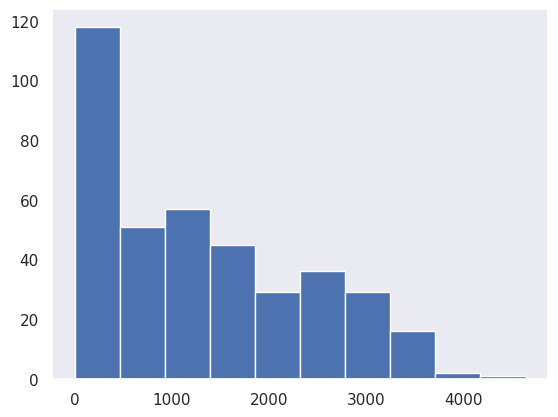

In [151]:
plt.hist(token_idf)

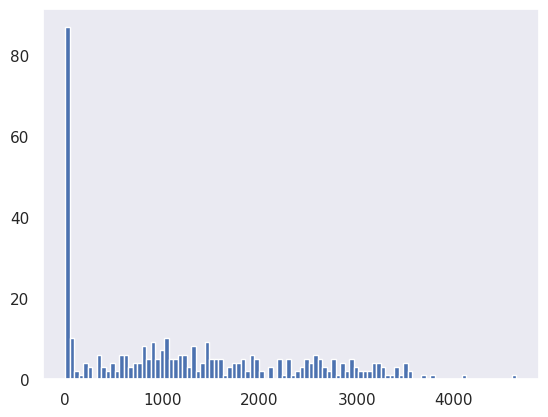

In [152]:
p = plt.hist(token_idf, bins=100)
plt.show()

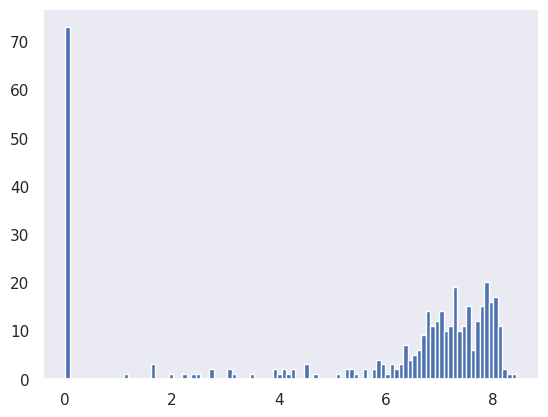

In [153]:
p = plt.hist(np.log(1+token_idf), bins=100)
plt.show()

In [154]:
tokens_vector_idf = np.vstack(df['token_count_vector_idf'].values)
tokens_vector_idf.shape

(4639, 384)

In [25]:
from IConNet.acov.tfidf import extract_features_tfidf

In [26]:
from functools import partial

In [157]:
extract_features_fn = partial(extract_features_tfidf, corpus_idf=tokens_vector_idf,
                              window_length=16, window_stride=3, ngram=2)

In [158]:
df.iloc[21]

filename                                                     dia12_utt4.wav
emotion                                                             sadness
emotion_key                                                             sad
speaker                                                              Phoebe
gender                                                               female
duration                                                              5.421
split                                                                   dev
filepath                  ../../data/meld/full_release/MELD.Raw_audios/d...
tokens                    [240, 4, 240, 200, 265, 4, 153, 240, 265, 129,...
token_counter             {240: 6, 4: 232, 200: 10, 265: 8, 153: 10, 129...
token_count_vector        [3, 4, 4, 0, 232, 3, 1, 1, 0, 5, 2, 0, 1, 0, 2...
token_count_vector_idf    [1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, ...
Name: 21, dtype: object

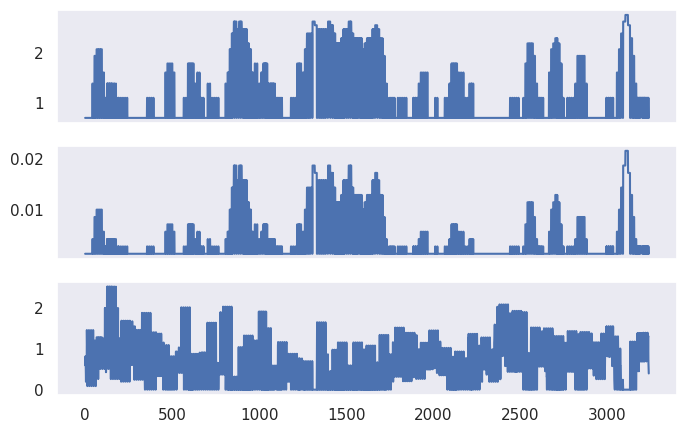

In [159]:
xx21 = extract_features_fn(df.iloc[21]['tokens'])
fig, axes = plt.subplots(3,1, figsize=(8,5), sharex=True)
for i in range(3):
    axes[i].plot(xx21[i])

In [160]:
df.iloc[13]

filename                                                      dia7_utt7.wav
emotion                                                               anger
emotion_key                                                             ang
speaker                                                                Ross
gender                                                                 male
duration                                                              4.337
split                                                                   dev
filepath                  ../../data/meld/full_release/MELD.Raw_audios/d...
tokens                    [4, 22, 196, 165, 108, 22, 195, 108, 36, 4, 49...
token_counter             {4: 85, 22: 13, 196: 12, 165: 4, 108: 20, 195:...
token_count_vector        [0, 1, 7, 6, 85, 3, 0, 0, 0, 1, 9, 0, 0, 0, 14...
token_count_vector_idf    [0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, ...
Name: 13, dtype: object

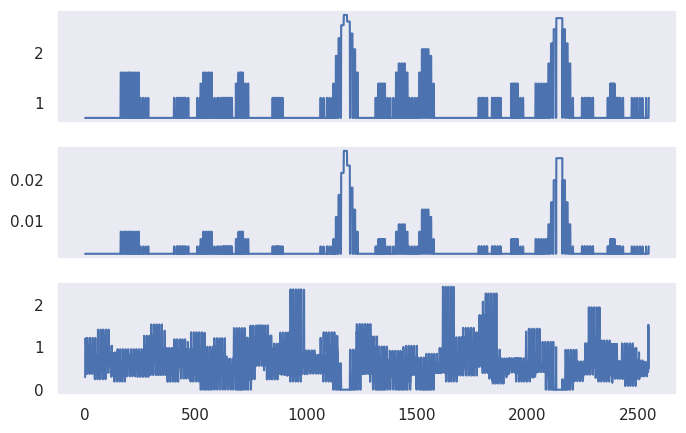

In [161]:
xx13 = extract_features_fn(df.iloc[13]['tokens'])
fig, axes = plt.subplots(3,1, figsize=(8,5), sharex=True)
for i in range(3):
    axes[i].plot(xx13[i])

In [179]:
df['tf_idf'] = df['tokens'].apply(extract_features_fn)

In [180]:
np.min(df['tf_idf'].apply(np.min))

-0.000597605072308313

In [181]:
torch.nn.utils.rnn.pad_sequence(
    [torch.tensor(d.T, dtype=torch.float) for d in df['tf_idf'].values[:3]],
    batch_first=True, padding_value=-1.0).shape

torch.Size([3, 1875, 3])

In [182]:
padded_tensors_tfidf = torch.nn.utils.rnn.pad_sequence(
    [torch.tensor(d.T, dtype=torch.float) for d in df['tf_idf'].values],
    batch_first=True, padding_value=-1.0)
padded_tensors_tfidf.shape

torch.Size([4639, 6135, 3])

In [183]:
padded_tfidf = padded_tensors_tfidf.mT.numpy()
padded_tfidf.shape

(4639, 3, 6135)

In [184]:
out_file_path = f'{data_dir}{dataset_name}/preprocessing/{dataset_name}.scb_tfidf.npy'
np.save(out_file_path, padded_tfidf, allow_pickle=True)

In [185]:
out_file_path = f'{data_dir}{dataset_name}/preprocessing/{dataset_name}.scb_tokens_vector_idf.npy'
np.save(out_file_path, tokens_vector_idf, allow_pickle=True)

In [186]:
out_file_path = f'{data_dir}{dataset_name}/preprocessing/{dataset_name}.scb_tokens_df.csv'
df.to_csv(out_file_path, header=True, index=False)

In [187]:
df['emotion_key']

0       sad
1       sad
2       ang
3       ang
4       ang
       ... 
4634    neu
4635    neu
4636    neu
4637    neu
4638    neu
Name: emotion_key, Length: 4639, dtype: object

In [188]:
out_file_path = f'{data_dir}{dataset_name}/preprocessing/{dataset_name}.label_emotion_key.npy'
np.save(out_file_path, df['emotion_key'].values, allow_pickle=True)

In [27]:
from omegaconf import OmegaConf as ocf

dataset_config_path = f'config/dataset/{dataset_name}.yaml'
dataset_config = ocf.load(dataset_config_path)
dataset_config['feature_name'] = 'scb_tfidf'
dataset_config['label_name'] = 'label_emotion_key'
print(dataset_config)

{'name': 'meld', 'dataset_class': 'WaveformDataset', 'root': 'meld/', 'audio_dir': 'full_release/', 'feature_dir': 'preprocessing/', 'label_name': 'label_emotion_key', 'feature_name': 'scb_tfidf', 'num_classes': 4, 'label_values': ['neu', 'hap', 'sad', 'ang'], 'classnames': ['neu', 'hap', 'sad', 'ang'], 'target_labels': ['ang', 'neu', 'sad', 'hap']}


In [28]:
from IConNet.trainer.train_torch import get_dataloader

train_loader, test_loader, batch_size = get_dataloader(
    dataset_config, data_dir, batch_size=16)
print(batch_size)

16


In [29]:
from IConNet.trainer.train_torch import Trainer_SCB10
import torch.optim as optim
from pprint import pprint

class Trainer_custom(Trainer_SCB10):
    def __init__(
            self, 
            batch_size, log_dir, experiment_prefix, device,
            eval_ratio: float=0.2,
            gradient_clip_val: float=0,
            accumulate_grad_batches: int=1,

    ):
        super().__init__(
            batch_size, log_dir, experiment_prefix, device,
            eval_ratio, gradient_clip_val, accumulate_grad_batches)

    def setup(self, model, lr=1e-3):
        super().setup(model=None, lr=lr)
        self.model = model
        self.train_losses_detail = []

    def train_step(self):
        device = self.device
        self.model.train()
        loss = torch.tensor(0., dtype=torch.float64, requires_grad=True)
        for batch_idx, (data, target) in enumerate(self.train_loader):
            data = data.to(device)
            target = target.to(device)
            logits = self.model(data)
            loss = loss + F.cross_entropy(logits.squeeze(), target)
            del data, target
            gc.collect()
            torch.cuda.empty_cache()
            if batch_idx % self.accumulate_grad_batches:
                self.optimizer.zero_grad()
                loss.backward()
                self.clip_gradient()
                self.optimizer.step()
                self.current_step += 1
                loss = loss.item()
                self.train_losses.append(loss)
                if batch_idx % self.val_check_batches == 0: 
                    message = self.gen_log_message(
                        batch_idx, loss, loss_detail=None,
                        memory=None
                    )    
                    self.eval_step(loss=loss, message=message)
                loss = torch.tensor(0., dtype=torch.float64, requires_grad=True)
            self._update_progress_bar()
            
    def fit(self, n_epoch=10, lr=None, test_n_epoch=1):
        device = self.device
        self.total_batches = self.train_batches + self.test_batches
        self.pbar_update = 1/self.total_batches
        if lr is not None:
            self.lr = lr
        self.optimizer = optim.RAdam(self.learnable_parameters, lr=self.lr)
        self.scheduler = optim.lr_scheduler.OneCycleLR(
            self.optimizer, max_lr=0.1,
            steps_per_epoch=self.train_batches, 
            epochs=n_epoch)
        self.model.to(device)
        with tqdm(total=n_epoch) as pbar:
            self.pbar = pbar
            for epoch in range(n_epoch):
                self.current_epoch += 1
                self.train_step()
                self.scheduler.step()
                is_test_epoch = (test_n_epoch is not None and test_n_epoch > 0 and epoch % test_n_epoch == 0)   
                if is_test_epoch:
                    metrics, metrics_details, confusion_matrix = self.test_step()
                    pprint(metrics.compute())
                    pprint(metrics_details.compute())
                    pprint(confusion_matrix.compute())
                    self.save()
                
        self.model.to('cpu')  

In [193]:
from IConNet.nn.model import M11

In [194]:
model_config_path = 'config/model/m10.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M10', 'description': 'gated residual FirConv', 'fe': {'n_block': 2, 'n_channel': [64, 64], 'kernel_size': [511, 127], 'stride': [2, 8], 'window_k': [2, 9], 'residual_connection_type': 'concat', 'pooling': 'max'}, 'cls': {'n_block': 2, 'n_hidden_dim': [128, 128]}}

In [195]:
model = M11(config=model_config,
           n_input=3, n_output=4)
model

M11(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2SeqBlocks(
    (blocks): LSTM(64, 64, batch_first=True)
  )
  (cls_hea

In [196]:
trainer = Trainer_custom(batch_size=batch_size, log_dir=log_dir, 
                  experiment_prefix=experiment_prefix, device=device,
                 accumulate_grad_batches=2, gradient_clip_val=1.)

trainer.prepare(train_loader=train_loader, 
                test_loader=test_loader, 
                batch_size=batch_size)
trainer.setup(model, lr=1e-4)

In [197]:
trainer.fit(n_epoch=1000, test_n_epoch=10)

  0%|                           | 0.33429394812680074/1000 [00:39<214:18:22, 771.76s/it]

Epoch: 1	Loss: 2.696	Val_acc: 44/184 (23.91%)

Saved new best val model: ../scb12_models/meld/model.epoch=1.step=58.loss=2.696.val_acc=0.239.pt


  0%|                              | 1.000000000000008/1000 [02:09<48:34:59, 175.07s/it]

Correct: 261/928 (0.2812)
Saved new best test model: ../scb12_models/meld/model.epoch=1.step=115.test_acc=0.2812.pt
{'acc_unweighted': tensor(0.2500, device='cuda:0'),
 'acc_weighted': tensor(0.2812, device='cuda:0'),
 'f1s_unweighted': tensor(0.1098, device='cuda:0'),
 'f1s_weighted': tensor(0.1235, device='cuda:0'),
 'rocauc': tensor(0.5261, device='cuda:0'),
 'uar': tensor(0.2500, device='cuda:0'),
 'wap': tensor(0.0791, device='cuda:0')}
{'acc_detail': tensor([0., 0., 0., 1.], device='cuda:0'),
 'f1s_detail': tensor([0.0000, 0.0000, 0.0000, 0.4390], device='cuda:0'),
 'precision_detail': tensor([0.0000, 0.0000, 0.0000, 0.2812], device='cuda:0'),
 'recall_detail': tensor([0., 0., 0., 1.], device='cuda:0'),
 'rocauc_detail': tensor([0.5434, 0.5217, 0.5062, 0.5332], device='cuda:0')}
tensor([[  0,   0,   0, 258],
        [  0,   0,   0, 248],
        [  0,   0,   0, 161],
        [  0,   0,   0, 261]], device='cuda:0')


  0%|                             | 1.334293948126815/1000 [02:48<210:43:41, 759.63s/it]

Epoch: 2	Loss: 2.794	Val_acc: 57/184 (30.98%)

Saved new best val model: ../scb12_models/meld/model.epoch=2.step=173.loss=2.794.val_acc=0.310.pt


  0%|                            | 2.0000000000000253/1000 [03:58<207:50:07, 749.71s/it]

Epoch: 3	Loss: 2.796	Val_acc: 51/184 (27.72%)



  0%|                            | 2.6657060518731845/1000 [05:07<208:48:23, 753.71s/it]

Epoch: 4	Loss: 2.848	Val_acc: 51/184 (27.72%)



  0%|                             | 3.331412103746344/1000 [06:16<205:22:16, 741.81s/it]

Epoch: 5	Loss: 2.717	Val_acc: 48/184 (26.09%)



  0%|                             | 3.997118155619503/1000 [07:25<202:39:53, 732.52s/it]

Epoch: 6	Loss: 2.815	Val_acc: 44/184 (23.91%)



  0%|▏                            | 4.662824207492663/1000 [08:34<204:37:44, 740.12s/it]

Epoch: 7	Loss: 2.716	Val_acc: 53/184 (28.80%)



  1%|▏                            | 5.328530259365822/1000 [09:43<203:42:09, 737.26s/it]

Epoch: 8	Loss: 2.732	Val_acc: 51/184 (27.72%)



  1%|▏                            | 5.994236311238981/1000 [10:52<204:40:12, 741.26s/it]

Epoch: 9	Loss: 2.778	Val_acc: 51/184 (27.72%)



  1%|▏                             | 6.65994236311214/1000 [12:01<202:44:16, 734.75s/it]

Epoch: 10	Loss: 2.751	Val_acc: 41/184 (22.28%)



  1%|▏                              | 7.3256484149853/1000 [13:10<206:05:26, 747.40s/it]

Epoch: 11	Loss: 2.798	Val_acc: 45/184 (24.46%)



  1%|▏                             | 7.991354466858459/1000 [14:38<46:28:31, 168.66s/it]

Correct: 258/928 (0.2780)
{'acc_unweighted': tensor(0.2500, device='cuda:0'),
 'acc_weighted': tensor(0.2780, device='cuda:0'),
 'f1s_unweighted': tensor(0.1088, device='cuda:0'),
 'f1s_weighted': tensor(0.1210, device='cuda:0'),
 'rocauc': tensor(0.5379, device='cuda:0'),
 'uar': tensor(0.2500, device='cuda:0'),
 'wap': tensor(0.0773, device='cuda:0')}
{'acc_detail': tensor([1., 0., 0., 0.], device='cuda:0'),
 'f1s_detail': tensor([0.4351, 0.0000, 0.0000, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.2780, 0.0000, 0.0000, 0.0000], device='cuda:0'),
 'recall_detail': tensor([1., 0., 0., 0.], device='cuda:0'),
 'rocauc_detail': tensor([0.5487, 0.5345, 0.5515, 0.5171], device='cuda:0')}
tensor([[258,   0,   0,   0],
        [248,   0,   0,   0],
        [161,   0,   0,   0],
        [261,   0,   0,   0]], device='cuda:0')


  1%|▏                             | 8.32564841498534/1000 [15:16<201:33:07, 731.68s/it]

Epoch: 12	Loss: 2.788	Val_acc: 48/184 (26.09%)



  1%|▎                            | 8.991354466858704/1000 [16:25<203:05:57, 737.79s/it]

Epoch: 13	Loss: 2.772	Val_acc: 59/184 (32.07%)

Saved new best val model: ../scb12_models/meld/model.epoch=13.step=1438.loss=2.772.val_acc=0.321.pt


  1%|▎                            | 9.657060518732068/1000 [17:34<206:42:21, 751.40s/it]

Epoch: 14	Loss: 2.793	Val_acc: 51/184 (27.72%)



  1%|▎                           | 10.322766570605433/1000 [18:43<206:24:58, 750.85s/it]

Epoch: 15	Loss: 2.842	Val_acc: 51/184 (27.72%)



  1%|▎                           | 10.988472622478797/1000 [19:52<203:13:22, 739.73s/it]

Epoch: 16	Loss: 2.863	Val_acc: 42/184 (22.83%)



  1%|▎                           | 11.654178674352162/1000 [21:02<209:51:29, 764.40s/it]

Epoch: 17	Loss: 2.632	Val_acc: 42/184 (22.83%)



  1%|▎                           | 12.319884726225526/1000 [22:12<206:39:37, 753.26s/it]

Epoch: 18	Loss: 2.650	Val_acc: 43/184 (23.37%)



  1%|▍                            | 12.98559077809889/1000 [23:22<207:28:03, 756.71s/it]

Epoch: 19	Loss: 2.792	Val_acc: 41/184 (22.28%)



  1%|▍                           | 13.651296829972255/1000 [24:32<206:06:10, 752.24s/it]

Epoch: 20	Loss: 2.787	Val_acc: 45/184 (24.46%)



  1%|▍                            | 14.31700288184562/1000 [25:42<208:26:40, 761.30s/it]

Epoch: 21	Loss: 2.664	Val_acc: 45/184 (24.46%)



  1%|▍                            | 14.982708933718984/1000 [27:10<46:02:43, 168.28s/it]

Correct: 277/928 (0.2985)
Saved new best test model: ../scb12_models/meld/model.epoch=21.step=2415.test_acc=0.2985.pt
{'acc_unweighted': tensor(0.2669, device='cuda:0'),
 'acc_weighted': tensor(0.2985, device='cuda:0'),
 'f1s_unweighted': tensor(0.1915, device='cuda:0'),
 'f1s_weighted': tensor(0.2142, device='cuda:0'),
 'rocauc': tensor(0.5264, device='cuda:0'),
 'uar': tensor(0.2669, device='cuda:0'),
 'wap': tensor(0.1672, device='cuda:0')}
{'acc_detail': tensor([0.5543, 0.0000, 0.0000, 0.5134], device='cuda:0'),
 'f1s_detail': tensor([0.3813, 0.0000, 0.0000, 0.3845], device='cuda:0'),
 'precision_detail': tensor([0.2907, 0.0000, 0.0000, 0.3073], device='cuda:0'),
 'recall_detail': tensor([0.5543, 0.0000, 0.0000, 0.5134], device='cuda:0'),
 'rocauc_detail': tensor([0.5193, 0.5234, 0.5385, 0.5243], device='cuda:0')}
tensor([[143,   0,   0, 115],
        [131,   0,   0, 117],
        [ 91,   0,   0,  70],
        [127,   0,   0, 134]], device='cuda:0')


  2%|▍                           | 15.317002881845868/1000 [27:48<199:48:03, 730.47s/it]

Epoch: 22	Loss: 2.868	Val_acc: 43/184 (23.37%)



  2%|▍                           | 15.982708933719232/1000 [28:58<201:49:54, 738.40s/it]

Epoch: 23	Loss: 2.908	Val_acc: 39/184 (21.20%)



  2%|▍                           | 16.648414985592595/1000 [30:07<201:33:01, 737.87s/it]

Epoch: 24	Loss: 2.882	Val_acc: 45/184 (24.46%)



  2%|▌                            | 17.31412103746596/1000 [31:16<202:41:45, 742.56s/it]

Epoch: 25	Loss: 2.713	Val_acc: 43/184 (23.37%)



  2%|▌                           | 17.979827089339324/1000 [32:25<207:37:08, 761.11s/it]

Epoch: 26	Loss: 2.750	Val_acc: 39/184 (21.20%)



  2%|▌                           | 18.645533141212688/1000 [33:35<200:02:40, 733.84s/it]

Epoch: 27	Loss: 2.736	Val_acc: 44/184 (23.91%)



  2%|▌                           | 19.311239193086053/1000 [34:44<200:47:07, 737.06s/it]

Epoch: 28	Loss: 2.737	Val_acc: 43/184 (23.37%)



  2%|▌                           | 19.976945244959417/1000 [35:53<199:36:01, 733.21s/it]

Epoch: 29	Loss: 2.665	Val_acc: 43/184 (23.37%)



  2%|▌                            | 20.64265129683278/1000 [37:04<206:23:24, 758.67s/it]

Epoch: 30	Loss: 2.677	Val_acc: 53/184 (28.80%)



  2%|▌                           | 21.308357348706146/1000 [38:13<200:59:52, 739.35s/it]

Epoch: 31	Loss: 2.828	Val_acc: 41/184 (22.28%)



  2%|▋                             | 21.97406340057951/1000 [39:43<46:51:17, 172.47s/it]

Correct: 274/928 (0.2953)
{'acc_unweighted': tensor(0.2685, device='cuda:0'),
 'acc_weighted': tensor(0.2953, device='cuda:0'),
 'f1s_unweighted': tensor(0.1817, device='cuda:0'),
 'f1s_weighted': tensor(0.1989, device='cuda:0'),
 'rocauc': tensor(0.5289, device='cuda:0'),
 'uar': tensor(0.2685, device='cuda:0'),
 'wap': tensor(0.1605, device='cuda:0')}
{'acc_detail': tensor([0.7674, 0.3065, 0.0000, 0.0000], device='cuda:0'),
 'f1s_detail': tensor([0.4276, 0.2992, 0.0000, 0.0000], device='cuda:0'),
 'precision_detail': tensor([0.2964, 0.2923, 0.0000, 0.0000], device='cuda:0'),
 'recall_detail': tensor([0.7674, 0.3065, 0.0000, 0.0000], device='cuda:0'),
 'rocauc_detail': tensor([0.5211, 0.5279, 0.5429, 0.5237], device='cuda:0')}
tensor([[198,  60,   0,   0],
        [172,  76,   0,   0],
        [118,  43,   0,   0],
        [180,  81,   0,   0]], device='cuda:0')


  2%|▌                           | 22.308357348706394/1000 [40:22<200:24:01, 737.90s/it]

Epoch: 32	Loss: 2.780	Val_acc: 40/184 (21.74%)



  2%|▋                            | 22.97406340057976/1000 [41:33<202:39:24, 746.72s/it]

Epoch: 33	Loss: 2.732	Val_acc: 41/184 (22.28%)



  2%|▋                           | 23.639769452453123/1000 [42:43<203:47:50, 751.43s/it]

Epoch: 34	Loss: 2.754	Val_acc: 44/184 (23.91%)



  2%|▋                           | 24.305475504326488/1000 [43:53<201:29:31, 743.44s/it]

Epoch: 35	Loss: 2.810	Val_acc: 42/184 (22.83%)



  2%|▋                           | 24.971181556199852/1000 [45:04<207:27:43, 765.99s/it]

Epoch: 36	Loss: 2.741	Val_acc: 40/184 (21.74%)



  3%|▋                           | 25.636887608073216/1000 [46:12<198:46:41, 734.43s/it]

Epoch: 37	Loss: 2.722	Val_acc: 41/184 (22.28%)



  3%|▊                            | 26.30259365994658/1000 [47:22<201:49:27, 746.19s/it]

Epoch: 38	Loss: 2.823	Val_acc: 40/184 (21.74%)



  3%|▊                           | 26.968299711819945/1000 [48:32<209:15:25, 774.20s/it]

Epoch: 39	Loss: 2.724	Val_acc: 38/184 (20.65%)



  3%|▊                            | 27.63400576369331/1000 [49:42<199:24:11, 738.25s/it]

Epoch: 40	Loss: 2.752	Val_acc: 39/184 (21.20%)



  3%|▊                           | 28.299711815566674/1000 [50:51<201:22:47, 746.08s/it]

Epoch: 41	Loss: 2.879	Val_acc: 39/184 (21.20%)



  3%|▊                             | 28.96541786744004/1000 [52:20<46:28:26, 172.30s/it]

Correct: 274/928 (0.2953)
{'acc_unweighted': tensor(0.2637, device='cuda:0'),
 'acc_weighted': tensor(0.2953, device='cuda:0'),
 'f1s_unweighted': tensor(0.1881, device='cuda:0'),
 'f1s_weighted': tensor(0.2105, device='cuda:0'),
 'rocauc': tensor(0.5258, device='cuda:0'),
 'uar': tensor(0.2637, device='cuda:0'),
 'wap': tensor(0.1650, device='cuda:0')}
{'acc_detail': tensor([0.4419, 0.0000, 0.0000, 0.6130], device='cuda:0'),
 'f1s_detail': tensor([0.3524, 0.0000, 0.0000, 0.4000], device='cuda:0'),
 'precision_detail': tensor([0.2931, 0.0000, 0.0000, 0.2968], device='cuda:0'),
 'recall_detail': tensor([0.4419, 0.0000, 0.0000, 0.6130], device='cuda:0'),
 'rocauc_detail': tensor([0.5247, 0.5211, 0.5314, 0.5258], device='cuda:0')}
tensor([[114,   0,   0, 144],
        [103,   0,   0, 145],
        [ 71,   0,   0,  90],
        [101,   0,   0, 160]], device='cuda:0')


  3%|▊                           | 29.299711815566923/1000 [52:59<199:36:26, 740.28s/it]

Epoch: 42	Loss: 2.819	Val_acc: 42/184 (22.83%)



  3%|▊                           | 29.965417867440287/1000 [54:09<201:36:11, 748.19s/it]

Epoch: 43	Loss: 2.722	Val_acc: 40/184 (21.74%)



  3%|▉                             | 30.244956772339492/1000 [54:36<25:02:58, 92.99s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7cb32f731070>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
  3%|▉                            | 30.244956772339492/1000 [54:36<29:11:05, 108.34s/it]


KeyboardInterrupt: 

In [199]:
"""
Minimal (byte-level) Byte Pair Encoding tokenizer.

Algorithmically follows along the GPT tokenizer:
https://github.com/openai/gpt-2/blob/master/src/encoder.py

But:
- Does not handle the regular expression splitting pattern.
- Does not handle any special tokens.
"""

from IConNet.acov.bpe_base import Tokenizer, get_stats, merge


class BasicTokenizer(Tokenizer):

    def __init__(self):
        super().__init__()

    def train(self, text, vocab_size, verbose=False):
        assert vocab_size >= 256
        num_merges = vocab_size - 256

        # input text preprocessing
        text_bytes = text.encode("utf-8") # raw bytes
        ids = list(text_bytes) # list of integers in range 0..255

        # iteratively merge the most common pairs to create new tokens
        merges = {} # (int, int) -> int
        vocab = {idx: bytes([idx]) for idx in range(256)} # int -> bytes
        for i in range(num_merges):
            # count up the number of times every consecutive pair appears
            stats = get_stats(ids)
            # find the pair with the highest count
            pair = max(stats, key=stats.get)
            # mint a new token: assign it the next available id
            idx = 256 + i
            # replace all occurrences of pair in ids with idx
            ids = merge(ids, pair, idx)
            # save the merge
            merges[pair] = idx
            vocab[idx] = vocab[pair[0]] + vocab[pair[1]]
            # prints
            if verbose:
                print(f"merge {i+1}/{num_merges}: {pair} -> {idx} ({vocab[idx]}) had {stats[pair]} occurrences")

        # save class variables
        self.merges = merges # used in encode()
        self.vocab = vocab   # used in decode()

    def decode(self, ids):
        # given ids (list of integers), return Python string
        text_bytes = b"".join(self.vocab[idx] for idx in ids)
        text = text_bytes.decode("utf-8", errors="replace")
        return text

    def encode(self, text):
        # given a string text, return the token ids
        text_bytes = text.encode("utf-8") # raw bytes
        ids = list(text_bytes) # list of integers in range 0..255
        while len(ids) >= 2:
            # find the pair with the lowest merge index
            stats = get_stats(ids)
            pair = min(stats, key=lambda p: self.merges.get(p, float("inf")))
            # subtle: if there are no more merges available, the key will
            # result in an inf for every single pair, and the min will be
            # just the first pair in the list, arbitrarily
            # we can detect this terminating case by a membership check
            if pair not in self.merges:
                break # nothing else can be merged anymore
            # otherwise let's merge the best pair (lowest merge index)
            idx = self.merges[pair]
            ids = merge(ids, pair, idx)
        return ids

In [200]:
tokenizer = BasicTokenizer()
text = "aaabdaaabac"
tokenizer.train(text, 256 + 3) # 256 are the byte tokens, then do 3 merges
print(tokenizer.encode(text))
# [258, 100, 258, 97, 99]
print(tokenizer.decode([258, 100, 258, 97, 99]))

[258, 100, 258, 97, 99]
aaabdaaabac


In [203]:
tokenizer.vocab

{0: b'\x00',
 1: b'\x01',
 2: b'\x02',
 3: b'\x03',
 4: b'\x04',
 5: b'\x05',
 6: b'\x06',
 7: b'\x07',
 8: b'\x08',
 9: b'\t',
 10: b'\n',
 11: b'\x0b',
 12: b'\x0c',
 13: b'\r',
 14: b'\x0e',
 15: b'\x0f',
 16: b'\x10',
 17: b'\x11',
 18: b'\x12',
 19: b'\x13',
 20: b'\x14',
 21: b'\x15',
 22: b'\x16',
 23: b'\x17',
 24: b'\x18',
 25: b'\x19',
 26: b'\x1a',
 27: b'\x1b',
 28: b'\x1c',
 29: b'\x1d',
 30: b'\x1e',
 31: b'\x1f',
 32: b' ',
 33: b'!',
 34: b'"',
 35: b'#',
 36: b'$',
 37: b'%',
 38: b'&',
 39: b"'",
 40: b'(',
 41: b')',
 42: b'*',
 43: b'+',
 44: b',',
 45: b'-',
 46: b'.',
 47: b'/',
 48: b'0',
 49: b'1',
 50: b'2',
 51: b'3',
 52: b'4',
 53: b'5',
 54: b'6',
 55: b'7',
 56: b'8',
 57: b'9',
 58: b':',
 59: b';',
 60: b'<',
 61: b'=',
 62: b'>',
 63: b'?',
 64: b'@',
 65: b'A',
 66: b'B',
 67: b'C',
 68: b'D',
 69: b'E',
 70: b'F',
 71: b'G',
 72: b'H',
 73: b'I',
 74: b'J',
 75: b'K',
 76: b'L',
 77: b'M',
 78: b'N',
 79: b'O',
 80: b'P',
 81: b'Q',
 82: b'R',
 83: b'

In [201]:
list('aaabdaaabac'.encode("utf-8"))

[97, 97, 97, 98, 100, 97, 97, 97, 98, 97, 99]

In [202]:
bytes([97])

b'a'

In [259]:
from IConNet.acov.bpe_base import Tokenizer, get_stats, merge


class NumericTokenizer(Tokenizer):

    def __init__(self, num_tokens):
        super().__init__(num_tokens)

    def train(self, tokens, vocab_size, verbose=False):
        """
        tokens: list of integers in range 0..num_tokens
        """
        assert vocab_size >= self.num_tokens
        num_merges = vocab_size - self.num_tokens
        ids = list(tokens) # 

        # iteratively merge the most common pairs to create new tokens
        merges = {} # (int, int) -> int
        vocab = {idx: (idx,) for idx in range(self.num_tokens)}
        for i in range(num_merges):
            # count up the number of times every consecutive pair appears
            stats = get_stats(ids)
            # find the pair with the highest count
            pair = max(stats, key=stats.get)
            # mint a new token: assign it the next available id
            idx = self.num_tokens + i
            # replace all occurrences of pair in ids with idx
            ids = merge(ids, pair, idx)
            # save the merge
            merges[pair] = idx
            vocab[idx] = (*vocab[pair[0]], *vocab[pair[1]])
            # prints
            if verbose:
                print(f"merge {i+1}/{num_merges}: {pair} -> {idx} ({vocab[idx]}) had {stats[pair]} occurrences")

        # save class variables
        self.merges = merges # used in encode()
        self.vocab = vocab   # used in decode()

    def decode(self, ids):
        # given ids (list of integers), return Python string
        decoded_ids = [self.vocab[idx] for idx in ids]
        decoded_ids = np.concatenate([[i for i in d] for d in decoded_ids]).tolist()
        return decoded_ids

    def encode(self, tokens):
        """ """
        # given a list of ids (tokens), return the BPE encoded ids
        ids = list(tokens)
        while len(ids) >= 2:
            # find the pair with the lowest merge index
            stats = get_stats(ids)
            pair = min(stats, key=lambda p: self.merges.get(p, float("inf")))
            # subtle: if there are no more merges available, the key will
            # result in an inf for every single pair, and the min will be
            # just the first pair in the list, arbitrarily
            # we can detect this terminating case by a membership check
            if pair not in self.merges:
                break # nothing else can be merged anymore
            # otherwise let's merge the best pair (lowest merge index)
            idx = self.merges[pair]
            ids = merge(ids, pair, idx)
        return ids

In [224]:
all_tokens_list.shape

(1981455,)

In [260]:
tokenizer = NumericTokenizer(num_tokens=384)
tokenizer.train(all_tokens_list, vocab_size=2000)

In [261]:
print(tokenizer.encode(df.iloc[21]['tokens']))

[655, 240, 200, 632, 153, 506, 129, 200, 302, 530, 456, 4, 30, 815, 815, 30, 731, 30, 995, 40, 995, 132, 995, 793, 1358, 834, 316, 995, 316, 163, 416, 503, 19, 1214, 227, 215, 102, 0, 613, 102, 367, 528, 102, 849, 227, 643, 4, 530, 358, 316, 5, 14, 106, 386, 34, 1969, 145, 635, 30, 361, 361, 501, 1594, 94, 509, 367, 158, 391, 56, 250, 1651, 1129, 129, 35, 1762, 655, 616, 235, 386, 9, 456, 385, 1763, 153, 35, 56, 435, 1130, 251, 1993, 222, 524, 56, 399, 373, 1301, 465, 222, 1243, 553, 887, 357, 1652, 1498, 385, 274, 460, 173, 391, 363, 385, 1076, 365, 1354, 679, 133, 385, 133, 384, 373, 825, 384, 512, 563, 253, 384, 305, 517, 1173, 131, 468, 399, 328, 677, 4, 1357, 204, 299, 386, 889, 222, 246, 100, 385, 69, 513, 168, 562, 335, 1064, 562, 168, 1856, 895, 75, 442, 185, 388, 1109, 338, 391, 1409, 1708, 80, 508, 1673, 829, 1234, 649, 253, 984, 253, 560, 367, 426, 124, 145, 30, 1032, 1080, 497, 38, 38, 555, 259, 352, 201, 379, 70, 564, 453, 317, 453, 570, 444, 444, 581, 843, 545, 254, 1720,

In [262]:
print(tokenizer.encode(df.iloc[13]['tokens']))

[1188, 196, 165, 1537, 980, 701, 49, 36, 550, 255, 677, 1156, 296, 471, 332, 169, 741, 673, 106, 250, 1169, 609, 259, 14, 511, 1193, 319, 532, 368, 90, 187, 716, 242, 1157, 1646, 644, 153, 367, 327, 332, 194, 100, 1619, 417, 130, 276, 131, 332, 293, 163, 958, 255, 546, 57, 429, 22, 494, 349, 1193, 1705, 201, 759, 379, 392, 90, 837, 352, 1611, 141, 252, 195, 14, 688, 388, 1009, 34, 544, 195, 525, 891, 67, 384, 544, 1188, 698, 1923, 259, 384, 219, 3, 238, 149, 385, 1, 819, 1275, 1258, 195, 165, 830, 149, 108, 111, 4, 214, 20, 40, 361, 1622, 732, 97, 1707, 1222, 143, 374, 251, 423, 295, 84, 1365, 79, 113, 27, 453, 394, 48, 22, 1592, 149, 1896, 319, 724, 812, 219, 931, 1143, 371, 469, 1370, 349, 352, 1611, 141, 252, 480, 531, 36, 780, 167, 962, 1198, 252, 195, 26, 3, 317, 158, 77, 713, 609, 32, 241, 586, 396, 54, 386, 449, 90, 257, 89, 894, 396, 196, 1638, 391, 409, 58, 298, 198, 1451, 546, 257, 14, 196, 495, 387, 191, 79, 893, 641, 1934, 1383, 609, 195, 599, 196, 48, 394, 257, 14, 196, 12

In [265]:
print(tokenizer.decode([27, 453, 394, 48, 22, 1592, 149, 1896]))

[27, 187, 16, 381, 381, 48, 22, 196, 108, 108, 196, 149, 219, 22]


In [266]:
tokenizer.vocab

{0: (0,),
 1: (1,),
 2: (2,),
 3: (3,),
 4: (4,),
 5: (5,),
 6: (6,),
 7: (7,),
 8: (8,),
 9: (9,),
 10: (10,),
 11: (11,),
 12: (12,),
 13: (13,),
 14: (14,),
 15: (15,),
 16: (16,),
 17: (17,),
 18: (18,),
 19: (19,),
 20: (20,),
 21: (21,),
 22: (22,),
 23: (23,),
 24: (24,),
 25: (25,),
 26: (26,),
 27: (27,),
 28: (28,),
 29: (29,),
 30: (30,),
 31: (31,),
 32: (32,),
 33: (33,),
 34: (34,),
 35: (35,),
 36: (36,),
 37: (37,),
 38: (38,),
 39: (39,),
 40: (40,),
 41: (41,),
 42: (42,),
 43: (43,),
 44: (44,),
 45: (45,),
 46: (46,),
 47: (47,),
 48: (48,),
 49: (49,),
 50: (50,),
 51: (51,),
 52: (52,),
 53: (53,),
 54: (54,),
 55: (55,),
 56: (56,),
 57: (57,),
 58: (58,),
 59: (59,),
 60: (60,),
 61: (61,),
 62: (62,),
 63: (63,),
 64: (64,),
 65: (65,),
 66: (66,),
 67: (67,),
 68: (68,),
 69: (69,),
 70: (70,),
 71: (71,),
 72: (72,),
 73: (73,),
 74: (74,),
 75: (75,),
 76: (76,),
 77: (77,),
 78: (78,),
 79: (79,),
 80: (80,),
 81: (81,),
 82: (82,),
 83: (83,),
 84: (84,),


In [267]:
tokenizer.merges

{(4, 4): 384,
 (384, 384): 385,
 (384, 4): 386,
 (385, 385): 387,
 (385, 4): 388,
 (93, 93): 389,
 (90, 90): 390,
 (385, 384): 391,
 (368, 368): 392,
 (149, 149): 393,
 (381, 381): 394,
 (385, 386): 395,
 (315, 315): 396,
 (387, 387): 397,
 (134, 134): 398,
 (153, 153): 399,
 (2, 2): 400,
 (355, 355): 401,
 (251, 38): 402,
 (242, 242): 403,
 (10, 10): 404,
 (53, 53): 405,
 (193, 193): 406,
 (310, 310): 407,
 (270, 5): 408,
 (14, 14): 409,
 (246, 204): 410,
 (56, 56): 411,
 (58, 58): 412,
 (129, 4): 413,
 (315, 243): 414,
 (293, 293): 415,
 (97, 97): 416,
 (372, 372): 417,
 (342, 342): 418,
 (364, 305): 419,
 (4, 158): 420,
 (219, 349): 421,
 (243, 243): 422,
 (76, 317): 423,
 (143, 143): 424,
 (251, 5): 425,
 (367, 164): 426,
 (387, 4): 427,
 (40, 40): 428,
 (36, 259): 429,
 (328, 328): 430,
 (308, 122): 431,
 (87, 87): 432,
 (365, 365): 433,
 (20, 20): 434,
 (4, 129): 435,
 (168, 168): 436,
 (257, 195): 437,
 (274, 274): 438,
 (303, 303): 439,
 (1, 1): 440,
 (6, 344): 441,
 (387, 384)

In [268]:
tokenizer.save("bpe_meld_2k", file_dir=log_dir)
# writes two files: toy.model (for loading) and toy.vocab (for viewing)

In [269]:
tokenizer2 = NumericTokenizer(num_tokens=384)
tokenizer2.load("bpe_meld_2k.model", file_dir=log_dir)

In [270]:
print(tokenizer2.decode([4, 22, 196, 165, 108, 22, 980]))

[4, 22, 196, 165, 108, 22, 195, 108]


In [271]:
print(tokenizer2.encode(df.iloc[21]['tokens']))

[655, 240, 200, 632, 153, 506, 129, 200, 302, 530, 456, 4, 30, 815, 815, 30, 731, 30, 995, 40, 995, 132, 995, 793, 1358, 834, 316, 995, 316, 163, 416, 503, 19, 1214, 227, 215, 102, 0, 613, 102, 367, 528, 102, 849, 227, 643, 4, 530, 358, 316, 5, 14, 106, 386, 34, 1969, 145, 635, 30, 361, 361, 501, 1594, 94, 509, 367, 158, 391, 56, 250, 1651, 1129, 129, 35, 1762, 655, 616, 235, 386, 9, 456, 385, 1763, 153, 35, 56, 435, 1130, 251, 1993, 222, 524, 56, 399, 373, 1301, 465, 222, 1243, 553, 887, 357, 1652, 1498, 385, 274, 460, 173, 391, 363, 385, 1076, 365, 1354, 679, 133, 385, 133, 384, 373, 825, 384, 512, 563, 253, 384, 305, 517, 1173, 131, 468, 399, 328, 677, 4, 1357, 204, 299, 386, 889, 222, 246, 100, 385, 69, 513, 168, 562, 335, 1064, 562, 168, 1856, 895, 75, 442, 185, 388, 1109, 338, 391, 1409, 1708, 80, 508, 1673, 829, 1234, 649, 253, 984, 253, 560, 367, 426, 124, 145, 30, 1032, 1080, 497, 38, 38, 555, 259, 352, 201, 379, 70, 564, 453, 317, 453, 570, 444, 444, 581, 843, 545, 254, 1720,

In [273]:
[len(v) for v in df[:3]['tokens'].apply(tokenizer.encode).values]

[206, 239, 182]

In [275]:
[len(v) for v in df[:3]['tokens'].values]

[355, 421, 342]

In [276]:
df['tokens_bpe2k'] = df['tokens'].apply(tokenizer.encode)

In [277]:
len_tokens_bpe2k = df['tokens_bpe2k'].apply(len).values

In [278]:
print(min(len_tokens_bpe2k), max(len_tokens_bpe2k))

23 801


In [281]:
padded_tensors_bpe2k = torch.nn.utils.rnn.pad_sequence(
    [torch.tensor(d, dtype=torch.float) for d in df['tokens_bpe2k'].values],
    batch_first=True, padding_value=-1.0)
padded_tensors_bpe2k.shape

torch.Size([4639, 801])

In [282]:
out_file_path = f'{data_dir}{dataset_name}/preprocessing/{dataset_name}.tokens_bpe2k.npy'
np.save(out_file_path, padded_tensors_bpe2k.numpy(), allow_pickle=True)

In [15]:
in_file_path = f'{data_dir}{dataset_name}/preprocessing/{dataset_name}.tokens_bpe2k.npy'
padded_tensors_bpe2k = np.load(in_file_path, allow_pickle=True)

In [16]:
def token_count_vectorize(token_counter, vocab_size=num_embeddings):
    vec = np.zeros(vocab_size, dtype=int)
    for t in token_counter:
        vec[t] = token_counter[t]
    return vec

In [292]:
df['bpe2k_token_counter'] = df['tokens_bpe2k'].apply(lambda x: Counter(x))
df['bpe2k_token_count_vector'] = df['bpe2k_token_counter'].apply(
    lambda x: token_count_vectorize(x, vocab_size=2000))

In [293]:
bpe2k_token_count_vector = df[df['emotion_key'].isin(target_labels)]['bpe2k_token_count_vector'].values
bpe2k_token_count_vector = np.vstack(bpe2k_token_count_vector)
bpe2k_token_count_vector.shape

(4639, 2000)

In [304]:
out_file_path = f'{data_dir}{dataset_name}/preprocessing/{dataset_name}.tokens_bpe2k_count.npy'
np.save(out_file_path, bpe2k_token_count_vector, allow_pickle=True)

In [18]:
in_file_path = f'{data_dir}{dataset_name}/preprocessing/{dataset_name}.tokens_bpe2k_count.npy'
bpe2k_token_count_vector = np.load(in_file_path, allow_pickle=True)

In [19]:
bpe2k_token_count_vector_norm = bpe2k_token_count_vector / bpe2k_token_count_vector.sum(axis=-1, keepdims=True)

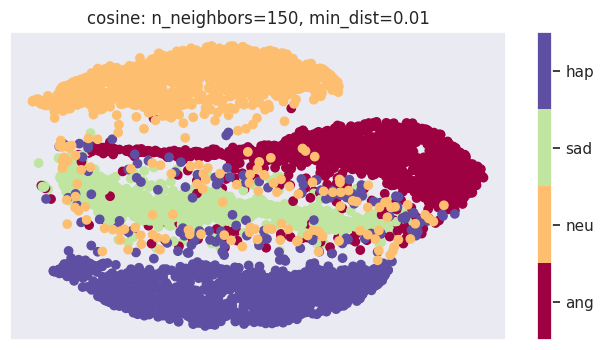

In [298]:
k = 150
min_dist = 0.01
umap_metric = 'cosine'

_, _ = train_and_visualize_embedding_umap(
    bpe2k_token_count_vector_norm, 
    target=data_y_4emo_encoded, 
    classnames=target_labels,
    mask_ratio=0.1,
    n_components=2,
    edgecolors=None,
    n_neighbors=k, min_dist=min_dist, metric=umap_metric,
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}'
)

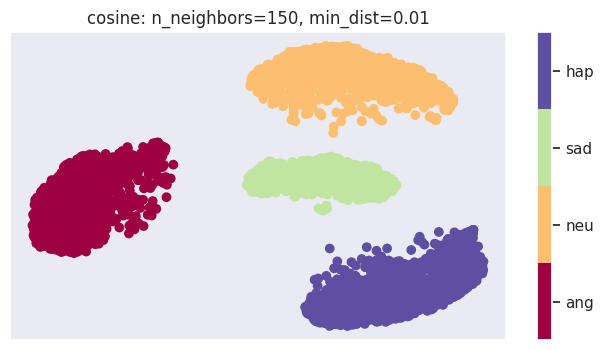

In [299]:
k = 150
min_dist = 0.01
umap_metric = 'cosine'

_, _ = train_and_visualize_embedding_umap(
    bpe2k_token_count_vector_norm, 
    target=data_y_4emo_encoded, 
    classnames=target_labels,
    # mask_ratio=0.1,
    n_components=2,
    edgecolors=None,
    n_neighbors=k, min_dist=min_dist, metric=umap_metric,
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}'
)

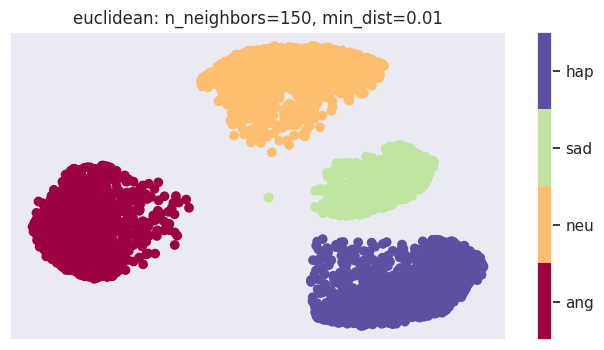

In [300]:
k = 150
min_dist = 0.01
umap_metric = 'euclidean'

_, _ = train_and_visualize_embedding_umap(
    bpe2k_token_count_vector_norm, 
    target=data_y_4emo_encoded, 
    classnames=target_labels,
    # mask_ratio=0.1,
    n_components=2,
    edgecolors=None,
    n_neighbors=k, min_dist=min_dist, metric=umap_metric,
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}'
)

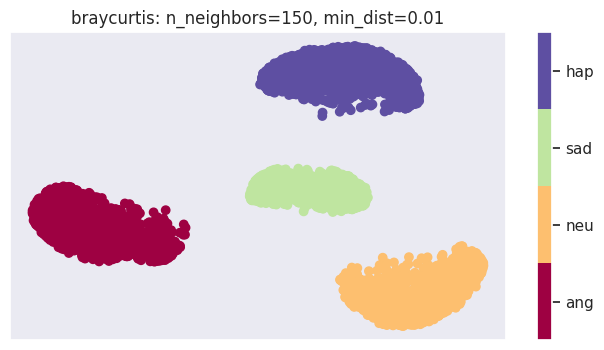

In [301]:
k = 150
min_dist = 0.01
umap_metric = 'braycurtis'

_, _ = train_and_visualize_embedding_umap(
    bpe2k_token_count_vector_norm, 
    target=data_y_4emo_encoded, 
    classnames=target_labels,
    # mask_ratio=0.1,
    n_components=2,
    edgecolors=None,
    n_neighbors=k, min_dist=min_dist, metric=umap_metric,
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}'
)

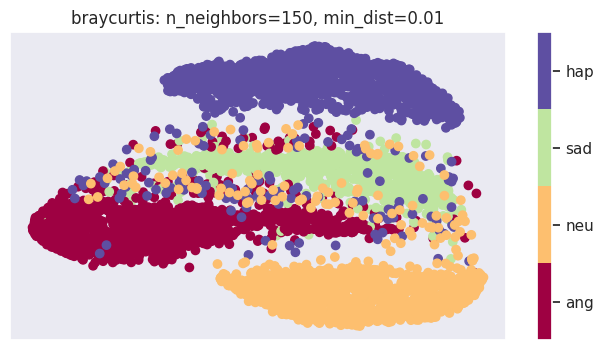

In [303]:
k = 150
min_dist = 0.01
umap_metric = 'braycurtis'

_, _ = train_and_visualize_embedding_umap(
    bpe2k_token_count_vector_norm, 
    target=data_y_4emo_encoded, 
    classnames=target_labels,
    mask_ratio=0.1,
    n_components=2,
    edgecolors=None,
    n_neighbors=k, min_dist=min_dist, metric=umap_metric,
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}'
)

In [31]:
x_train_bpe2k, x_test_bpe2k, y_train, y_test = train_test_split(
    bpe2k_token_count_vector_norm, data_y_4emo_encoded, test_size=0.2, 
    random_state=42, stratify=data_y_4emo_encoded)

In [32]:
scaler2 = StandardScaler().fit(x_train_bpe2k)
x_train_norm_scaled2 = scaler2.transform(x_train_bpe2k)
x_test_norm_scaled2 = scaler2.transform(x_test_bpe2k)

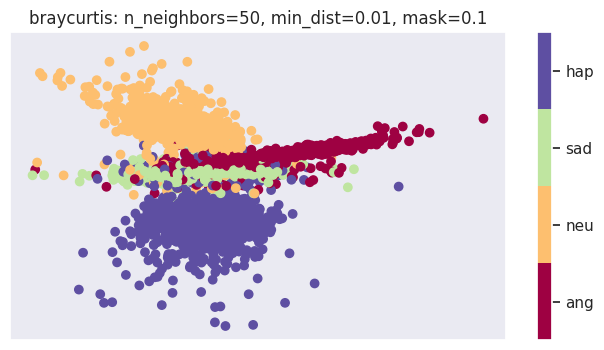

In [34]:
k = 50
min_dist = 0.01
umap_metric = 'braycurtis'
mask_ratio = 0.1

transformer2, x_train_transformed2 = train_and_visualize_embedding_umap(
    x_train_norm_scaled2, 
    target=y_train, 
    classnames=target_labels,
    mask_ratio=mask_ratio,
    n_components=256,
    edgecolors=None,
    n_neighbors=k, min_dist=min_dist, metric=umap_metric,
    title=f'{umap_metric}: n_neighbors={k}, min_dist={min_dist}, mask={mask_ratio}'
)

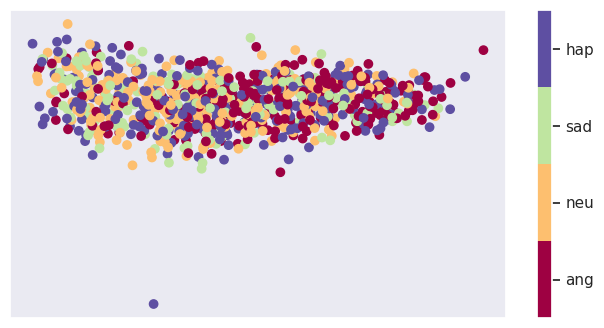

In [35]:
x_test_transformed2 = transform_and_visualize_umap(
    transformer2, x_test_norm_scaled2, y_test, target_labels)

              precision    recall  f1-score   support

           0       0.45      0.41      0.43       258
           1       0.31      0.35      0.33       248
           2       0.00      0.00      0.00       161
           3       0.30      0.47      0.36       261

    accuracy                           0.34       928
   macro avg       0.26      0.31      0.28       928
weighted avg       0.29      0.34      0.31       928

[[105  57   1  95]
 [ 36  88   0 124]
 [ 27  66   0  68]
 [ 63  76   0 122]]


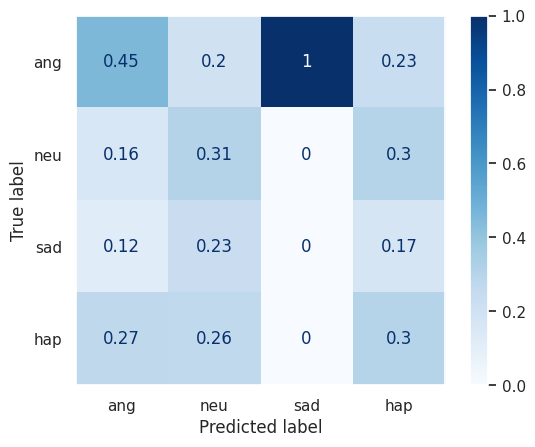

In [36]:
cls = MLPClassifier(
    (1024, 1024), 
    batch_size=64, learning_rate='adaptive', 
    learning_rate_init=0.0001, max_iter=10000, shuffle=True, 
    random_state=42, momentum=0.9, nesterovs_momentum=True, 
    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,)
train_skmodel(cls, x_train_transformed2, y_train, x_test_transformed2, y_test)

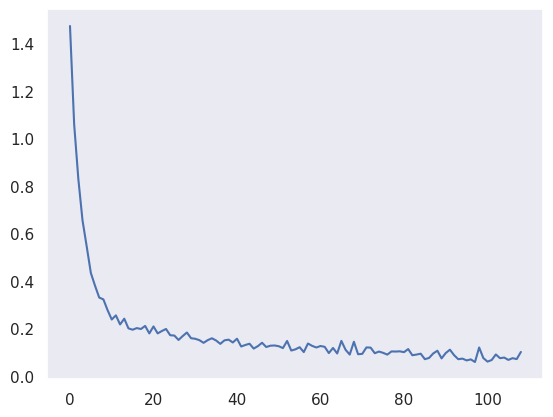

In [37]:
plt.plot(cls.loss_curve_)